In [125]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.preprocessing, sklearn.cluster, sklearn.metrics
import scipy.spatial
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, DBSCAN

In [2]:
df = pd.read_csv('players_fifa22.csv', index_col = 0)
df

Name                      FullName  Age  Height  Weight  \
ID                                                                             
158023           L. Messi                  Lionel Messi   34     170      72   
188545     R. Lewandowski            Robert Lewandowski   32     185      81   
20801   Cristiano Ronaldo  C. Ronaldo dos Santos Aveiro   36     187      83   
231747          K. Mbappé                 Kylian Mbappé   22     182      73   
200389           J. Oblak                     Jan Oblak   28     188      87   
...                   ...                           ...  ...     ...     ...   
262759           S. Black                 Stephen Black   19     180      75   
250978            Ma Zhen                       Zhen Ma   23     196      85   
261985         Yang Haoyu                    Haoyu Yang   20     183      77   
261977           He Siwei                      Siwei He   20     174      69   
261932      Chen Guoliang                 Guoliang Chen   22     186      70   

                                                PhotoUrl          Nationality  \
ID                                                                              
158023  https://cdn.sofifa.com/players/158/023/22_60.png            Argentina   
188545  https://cdn.sofifa.com/players/188/545/22_60.png               Poland   
20801   https://cdn.sofifa.com/players/020/801/22_60.png             Portugal   
231747  https://cdn.sofifa.com/players/231/747/22_60.png               France   
200389  https://cdn.sofifa.com/players/200/389/22_60.png             Slovenia   
...                                                  ...                  ...   
262759  https://cdn.sofifa.com/players/262/759/22_60.png  Republic of Ireland   
250978  https://cdn.sofifa.com/players/250/978/22_60.png             China PR   
261985  https://cdn.sofifa.com/players/261/985/22_60.png             China PR   
261977  https://cdn.sofifa.com/players/261/977/22_60.png             China PR   
261932  https://cdn.sofifa.com/players/261/932/22_60.png             China PR   

        Overall  Potential  Growth  ...  LMRating  CMRating RMRating  \
ID                                  ...                                
158023       93         93       0  ...        93        90       93   
188545       92         92       0  ...        87        83       87   
20801        91         91       0  ...        89        81       89   
231747       91         95       4  ...        92        84       92   
200389       91         93       2  ...        38        41       38   
...         ...        ...     ...  ...       ...       ...      ...   
262759       48         62      14  ...        36        35       36   
250978       48         52       4  ...        26        23       26   
261985       48         55       7  ...        36        35       36   
261977       48         58      10  ...        38        37       38   
261932       48         53       5  ...        35        35       35   

       LWBRating CDMRating  RWBRating  LBRating  CBRating RBRating  GKRating  
ID                                                                            
158023        69        67         69        64        53       64        22  
188545        67        69         67        64        63       64        22  
20801         66        62         66        63        56       63        23  
231747        70        66         70        66        57       66        21  
200389        35        39         35        35        36       35        92  
...          ...       ...        ...       ...       ...      ...       ...  
262759        44        43         44        47        50       47        15  
250978        26        23         26        26        26       26        49  
261985        46        45         46        48        50       48        15  
261977        46        45         46        49        50       49        17  
261932        46        44         46    

In [3]:
df.drop('Name',axis=1, inplace=True)
df.drop('FullName',axis=1, inplace=True)
df.drop('PhotoUrl',axis=1, inplace=True)

Zbavím dataset sloupců, které jsou pro clustering zbytečné.

In [4]:
df = df.sample(2000)

Jelikož je data set příliž velký a některé operace by mohly zabrat hodně času, tak použiju z něho je 2000 řádků.

In [5]:
df.isna().sum().sort_values(ascending=False)

NationalNumber       1911
NationalPosition     1911
ClubNumber              8
ContractUntil           8
ClubPosition            8
                     ... 
PassingTotal            0
ShootingTotal           0
PaceTotal               0
DefensiveWorkRate       0
GKRating                0
Length: 86, dtype: int64

In [6]:
df.NationalNumber.value_counts().head()

19.0    8
20.0    7
18.0    6
13.0    6
22.0    5
Name: NationalNumber, dtype: int64

In [7]:
df.NationalPosition.value_counts().head()

SUB    52
LB      5
CM      5
CB      4
CDM     4
Name: NationalPosition, dtype: int64

Sloupce NationalNumber a NationalPosition vyhodím z data setu protože obsahují převážně prázdné hodnoty

In [8]:
df.drop('NationalNumber',axis=1, inplace=True)
df.drop('NationalPosition',axis=1, inplace=True)

Další sloupce, které obsahují jen pár prázdných řádků vyhodím z data framu

In [9]:
df.dropna(subset = ["ClubNumber"], inplace=True)


In [10]:
df

Age  Height  Weight          Nationality  Overall  Potential  Growth  \
ID                                                                             
183774   31     188      78              England       72         72       0   
230249   25     189      84               Brazil       70         70       0   
236527   24     177      77            Argentina       74         80       6   
262732   19     194      77               Norway       60         75      15   
245455   22     166      59         Saudi Arabia       52         62      10   
...     ...     ...     ...                  ...      ...        ...     ...   
264450   21     178      74              Nigeria       68         78      10   
257303   23     191      84          Netherlands       65         73       8   
256415   18     182      70  Republic of Ireland       49         62      13   
258749   17     188      78              England       55         75      20   
261656   29     185      85        United States       56         58       2   

        TotalStats  BaseStats  Positions  ... LMRating CMRating  RMRating  \
ID                                        ...                               
183774        1367        288         CB  ...       42       52        42   
230249        1662        356     CDM,CB  ...       63       69        63   
236527        1888        405  CDM,CM,CB  ...       69       73        69   
262732        1462        320         ST  ...       57       51        57   
245455        1397        284         ST  ...       51       44        51   
...            ...        ...        ...  ...      ...      ...       ...   
264450        1726        372         RW  ...       68       61        68   
257303        1521        335         CB  ...       54       56        54   
256415        1289        269      RM,LM  ...       50       46        50   
258749        1411        311      ST,RM  ...       55       46        55   
261656        1012        301         GK  ...       26       30        26   

        LWBRating  CDMRating RWBRating  LBRating  CBRating  RBRating  GKRating  
ID                                                                              
183774         59         68        59        62        72        62        19  
230249         64         70        64        65        70        65        21  
236527         71         75        71        70        73        70        19  
262732         44         41        44        43        41        43        17  
245455         44         40        44        43        40        43        18  
...           ...        ...       ...       ...       ...       ...       ...  
264450         54         50        54        52        48        52        19  
257303         62         64        62        63        67        63        18  
256415         42         40        42        41        37        41        14  
258749         42         36        42        39        34        39        15  
261656         24         28        24        24        25        24        57  

[1992 rows x 84 columns]

In [11]:
df.isna().sum().sort_values(ascending=False)

Age                  0
Aggression           0
SlidingTackle        0
StandingTackle       0
Marking              0
                    ..
DefensiveWorkRate    0
AttackingWorkRate    0
SkillMoves           0
WeakFoot             0
GKRating             0
Length: 84, dtype: int64

Dále dataframe neosahuje žádné prázdné hodnoty.

In [12]:
pd.set_option( "display.max_columns", None)

In [13]:
df

Age  Height  Weight          Nationality  Overall  Potential  Growth  \
ID                                                                             
183774   31     188      78              England       72         72       0   
230249   25     189      84               Brazil       70         70       0   
236527   24     177      77            Argentina       74         80       6   
262732   19     194      77               Norway       60         75      15   
245455   22     166      59         Saudi Arabia       52         62      10   
...     ...     ...     ...                  ...      ...        ...     ...   
264450   21     178      74              Nigeria       68         78      10   
257303   23     191      84          Netherlands       65         73       8   
256415   18     182      70  Republic of Ireland       49         62      13   
258749   17     188      78              England       55         75      20   
261656   29     185      85        United States       56         58       2   

        TotalStats  BaseStats  Positions BestPosition               Club  \
ID                                                                         
183774        1367        288         CB           CB       Swansea City   
230249        1662        356     CDM,CB          CDM          Fortaleza   
236527        1888        405  CDM,CM,CB          CDM    Vélez Sarsfield   
262732        1462        320         ST           ST      FK Bodø/Glimt   
245455        1397        284         ST           ST           Al Batin   
...            ...        ...        ...          ...                ...   
264450        1726        372         RW           ST    Portimonense SC   
257303        1521        335         CB           CB       Lincoln City   
256415        1289        269      RM,LM          CAM         Derry City   
258749        1411        311      ST,RM           ST  Colchester United   
261656        1012        301         GK           GK   New York City FC   

        ValueEUR  WageEUR  ReleaseClause ClubPosition  ContractUntil  \
ID                                                                     
183774   1600000    19000        3000000           CB         2023.0   
230249   1600000     7000        3000000          CDM         2024.0   
236527   6000000    20000              0           CM         2021.0   
262732    600000      650        1100000          SUB         2024.0   
245455    180000     2000         333000          RES         2024.0   
...          ...      ...            ...          ...            ...   
264450   2700000     3000        6200000          SUB         2025.0   
257303   1500000     3000        2900000           CB         2023.0   
256415    110000      500         239000          RES         2021.0   
258749    350000      550         963000          SUB         2022.0   
261656    120000     1000         189000          RES         2021.0   

        ClubNumber  ClubJoined  OnLoad NationalTeam PreferredFoot  \
ID                                                                  
183774         2.0        2020   False  Not in team         Right   
230249        33.0        2021   False  Not in team         Right   
236527        35.0        2018    True  Not in team         Right   
262732        24.0        2021   False  Not in team          Left   
245455        15.0        2018   False  Not in team         Right   
...            ...         ...     ...          ...           ...   
264450        99.0        2021   False  Not in team          Left   
257303         4.0        2020   False  Not in team         Right   
256415        28.0        2020   False  Not in team         Right   
258749        34.0        2020   False  Not in team          Left   
261656        25.0        2021   False  Not in team         Right   

        IntReputation  WeakFoot  SkillMoves AttackingWorkRate  \
ID                                                              
183774       

In [14]:
df.OnLoad.value_counts()

False    1878
True      114
Name: OnLoad, dtype: int64

In [15]:
df['OnLoad'] = sklearn.preprocessing.OrdinalEncoder().fit_transform(df[['OnLoad']])

OnLoad je bud true nebo false tak to transformuju na 0 nebo 1

In [16]:
df.PreferredFoot.value_counts()

Right    1473
Left      519
Name: PreferredFoot, dtype: int64

In [17]:
df['PreferredFoot'] = sklearn.preprocessing.OrdinalEncoder().fit_transform(df[['PreferredFoot']])

In [18]:
df.PreferredFoot.value_counts()

1.0    1473
0.0     519
Name: PreferredFoot, dtype: int64

In [19]:
df.AttackingWorkRate.value_counts()

Medium    1298
High       588
Low        106
Name: AttackingWorkRate, dtype: int64

In [20]:
cats = ['Low',  'Medium', 'High']
enc = sklearn.preprocessing.OrdinalEncoder(categories = [cats])
df['AttackingWorkRate'] = enc.fit_transform(df[['AttackingWorkRate']])


In [21]:
df.AttackingWorkRate.value_counts()

1.0    1298
2.0     588
0.0     106
Name: AttackingWorkRate, dtype: int64

In [22]:
df.DefensiveWorkRate.value_counts()

Medium    1449
High       366
Low        177
Name: DefensiveWorkRate, dtype: int64

In [23]:
cats = ['Low',  'Medium', 'High']
enc = sklearn.preprocessing.OrdinalEncoder(categories = [cats])
df['DefensiveWorkRate'] = enc.fit_transform(df[['DefensiveWorkRate']])


In [24]:
df.DefensiveWorkRate.value_counts()

1.0    1449
2.0     366
0.0     177
Name: DefensiveWorkRate, dtype: int64

Sloupce DefensiveWorkRate a AttackingWorkRate jsem enkódoval pomocí OrdinalEncoder, protože atributu mají mezi sebou
vztah. A dá se říct, že ['Low',  'Medium', 'High'] odpovída [1,2,3]


In [25]:
df

Age  Height  Weight          Nationality  Overall  Potential  Growth  \
ID                                                                             
183774   31     188      78              England       72         72       0   
230249   25     189      84               Brazil       70         70       0   
236527   24     177      77            Argentina       74         80       6   
262732   19     194      77               Norway       60         75      15   
245455   22     166      59         Saudi Arabia       52         62      10   
...     ...     ...     ...                  ...      ...        ...     ...   
264450   21     178      74              Nigeria       68         78      10   
257303   23     191      84          Netherlands       65         73       8   
256415   18     182      70  Republic of Ireland       49         62      13   
258749   17     188      78              England       55         75      20   
261656   29     185      85        United States       56         58       2   

        TotalStats  BaseStats  Positions BestPosition               Club  \
ID                                                                         
183774        1367        288         CB           CB       Swansea City   
230249        1662        356     CDM,CB          CDM          Fortaleza   
236527        1888        405  CDM,CM,CB          CDM    Vélez Sarsfield   
262732        1462        320         ST           ST      FK Bodø/Glimt   
245455        1397        284         ST           ST           Al Batin   
...            ...        ...        ...          ...                ...   
264450        1726        372         RW           ST    Portimonense SC   
257303        1521        335         CB           CB       Lincoln City   
256415        1289        269      RM,LM          CAM         Derry City   
258749        1411        311      ST,RM           ST  Colchester United   
261656        1012        301         GK           GK   New York City FC   

        ValueEUR  WageEUR  ReleaseClause ClubPosition  ContractUntil  \
ID                                                                     
183774   1600000    19000        3000000           CB         2023.0   
230249   1600000     7000        3000000          CDM         2024.0   
236527   6000000    20000              0           CM         2021.0   
262732    600000      650        1100000          SUB         2024.0   
245455    180000     2000         333000          RES         2024.0   
...          ...      ...            ...          ...            ...   
264450   2700000     3000        6200000          SUB         2025.0   
257303   1500000     3000        2900000           CB         2023.0   
256415    110000      500         239000          RES         2021.0   
258749    350000      550         963000          SUB         2022.0   
261656    120000     1000         189000          RES         2021.0   

        ClubNumber  ClubJoined  OnLoad NationalTeam  PreferredFoot  \
ID                                                                   
183774         2.0        2020     0.0  Not in team            1.0   
230249        33.0        2021     0.0  Not in team            1.0   
236527        35.0        2018     1.0  Not in team            1.0   
262732        24.0        2021     0.0  Not in team            0.0   
245455        15.0        2018     0.0  Not in team            1.0   
...            ...         ...     ...          ...            ...   
264450        99.0        2021     0.0  Not in team            0.0   
257303         4.0        2020     0.0  Not in team            1.0   
256415        28.0        2020     0.0  Not in team            1.0   
258749        34.0        2020     0.0  Not in team            0.0   
261656        25.0        2021     0.0  Not in team            1.0   

        IntReputation  WeakFoot  SkillMoves  AttackingWorkRate  \
ID                                                              

In [26]:
df.columns

Index(['Age', 'Height', 'Weight', 'Nationality', 'Overall', 'Potential',
       'Growth', 'TotalStats', 'BaseStats', 'Positions', 'BestPosition',
       'Club', 'ValueEUR', 'WageEUR', 'ReleaseClause', 'ClubPosition',
       'ContractUntil', 'ClubNumber', 'ClubJoined', 'OnLoad', 'NationalTeam',
       'PreferredFoot', 'IntReputation', 'WeakFoot', 'SkillMoves',
       'AttackingWorkRate', 'DefensiveWorkRate', 'PaceTotal', 'ShootingTotal',
       'PassingTotal', 'DribblingTotal', 'DefendingTotal', 'PhysicalityTotal',
       'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys',
       'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
       'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance',
       'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
       'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
       'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving',
       'GKHandling', 'GKKicking', '

In [27]:
df.Nationality.value_counts()

England                 195
Germany                 122
Spain                   115
France                  103
Argentina                96
                       ... 
Honduras                  1
United Arab Emirates      1
Latvia                    1
Guyana                    1
Suriname                  1
Name: Nationality, Length: 102, dtype: int64

In [28]:
df.WageEUR.value_counts()

2000      306
500       232
1000      213
3000      173
4000      116
         ... 
69000       1
110000      1
67000       1
70000       1
170000      1
Name: WageEUR, Length: 101, dtype: int64

Dataset obsahuje mnoho dat ohledně fotbalových hráčů 

<AxesSubplot:xlabel='Height', ylabel='Count'>

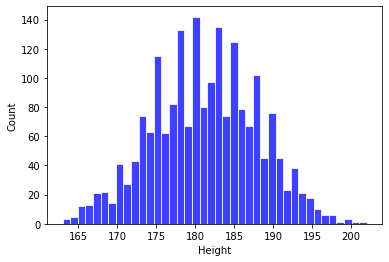

In [29]:
sns.histplot(df.Height, bins=40, edgecolor='white', color='blue')

<AxesSubplot:xlabel='Weight', ylabel='Count'>

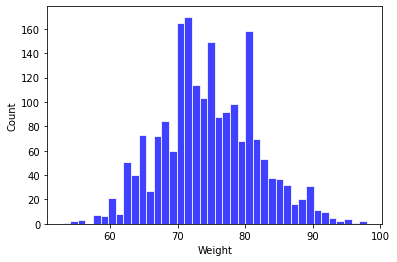

In [30]:
sns.histplot(df.Weight, bins=40, edgecolor='white', color='blue')

Z grafů jde vidět, že výška a váha hráčů je distribuována Gausovou křivkou.

<AxesSubplot:xlabel='WageEUR', ylabel='Count'>

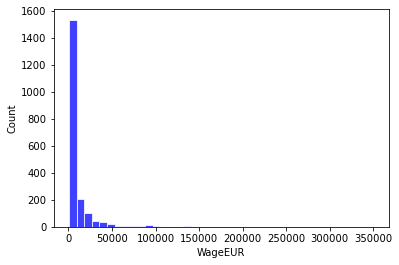

In [31]:
sns.histplot(df.WageEUR, bins=40, edgecolor='white', color='blue')

In [32]:
df.WageEUR.sort_values(ascending=False)

ID
192985    350000
165153    350000
231747    230000
189332    200000
212831    190000
           ...  
174443       500
264396       500
264566       500
246757       500
254029       500
Name: WageEUR, Length: 1992, dtype: int64

Z grafu jde vidět, že v platech je klesající trend. Nejlepší fotbalisti (jako Messi, Ronaldo atd.) berou kolem čtvrt miliónu eur. A někteří fotbalisti hrajou zadarmo, asi jen tak pro zábavu.

In [33]:
df

Age  Height  Weight          Nationality  Overall  Potential  Growth  \
ID                                                                             
183774   31     188      78              England       72         72       0   
230249   25     189      84               Brazil       70         70       0   
236527   24     177      77            Argentina       74         80       6   
262732   19     194      77               Norway       60         75      15   
245455   22     166      59         Saudi Arabia       52         62      10   
...     ...     ...     ...                  ...      ...        ...     ...   
264450   21     178      74              Nigeria       68         78      10   
257303   23     191      84          Netherlands       65         73       8   
256415   18     182      70  Republic of Ireland       49         62      13   
258749   17     188      78              England       55         75      20   
261656   29     185      85        United States       56         58       2   

        TotalStats  BaseStats  Positions BestPosition               Club  \
ID                                                                         
183774        1367        288         CB           CB       Swansea City   
230249        1662        356     CDM,CB          CDM          Fortaleza   
236527        1888        405  CDM,CM,CB          CDM    Vélez Sarsfield   
262732        1462        320         ST           ST      FK Bodø/Glimt   
245455        1397        284         ST           ST           Al Batin   
...            ...        ...        ...          ...                ...   
264450        1726        372         RW           ST    Portimonense SC   
257303        1521        335         CB           CB       Lincoln City   
256415        1289        269      RM,LM          CAM         Derry City   
258749        1411        311      ST,RM           ST  Colchester United   
261656        1012        301         GK           GK   New York City FC   

        ValueEUR  WageEUR  ReleaseClause ClubPosition  ContractUntil  \
ID                                                                     
183774   1600000    19000        3000000           CB         2023.0   
230249   1600000     7000        3000000          CDM         2024.0   
236527   6000000    20000              0           CM         2021.0   
262732    600000      650        1100000          SUB         2024.0   
245455    180000     2000         333000          RES         2024.0   
...          ...      ...            ...          ...            ...   
264450   2700000     3000        6200000          SUB         2025.0   
257303   1500000     3000        2900000           CB         2023.0   
256415    110000      500         239000          RES         2021.0   
258749    350000      550         963000          SUB         2022.0   
261656    120000     1000         189000          RES         2021.0   

        ClubNumber  ClubJoined  OnLoad NationalTeam  PreferredFoot  \
ID                                                                   
183774         2.0        2020     0.0  Not in team            1.0   
230249        33.0        2021     0.0  Not in team            1.0   
236527        35.0        2018     1.0  Not in team            1.0   
262732        24.0        2021     0.0  Not in team            0.0   
245455        15.0        2018     0.0  Not in team            1.0   
...            ...         ...     ...          ...            ...   
264450        99.0        2021     0.0  Not in team            0.0   
257303         4.0        2020     0.0  Not in team            1.0   
256415        28.0        2020     0.0  Not in team            1.0   
258749        34.0        2020     0.0  Not in team            0.0   
261656        25.0        2021     0.0  Not in team            1.0   

        IntReputation  WeakFoot  SkillMoves  AttackingWorkRate  \
ID                                                              

In [34]:
df

Age  Height  Weight          Nationality  Overall  Potential  Growth  \
ID                                                                             
183774   31     188      78              England       72         72       0   
230249   25     189      84               Brazil       70         70       0   
236527   24     177      77            Argentina       74         80       6   
262732   19     194      77               Norway       60         75      15   
245455   22     166      59         Saudi Arabia       52         62      10   
...     ...     ...     ...                  ...      ...        ...     ...   
264450   21     178      74              Nigeria       68         78      10   
257303   23     191      84          Netherlands       65         73       8   
256415   18     182      70  Republic of Ireland       49         62      13   
258749   17     188      78              England       55         75      20   
261656   29     185      85        United States       56         58       2   

        TotalStats  BaseStats  Positions BestPosition               Club  \
ID                                                                         
183774        1367        288         CB           CB       Swansea City   
230249        1662        356     CDM,CB          CDM          Fortaleza   
236527        1888        405  CDM,CM,CB          CDM    Vélez Sarsfield   
262732        1462        320         ST           ST      FK Bodø/Glimt   
245455        1397        284         ST           ST           Al Batin   
...            ...        ...        ...          ...                ...   
264450        1726        372         RW           ST    Portimonense SC   
257303        1521        335         CB           CB       Lincoln City   
256415        1289        269      RM,LM          CAM         Derry City   
258749        1411        311      ST,RM           ST  Colchester United   
261656        1012        301         GK           GK   New York City FC   

        ValueEUR  WageEUR  ReleaseClause ClubPosition  ContractUntil  \
ID                                                                     
183774   1600000    19000        3000000           CB         2023.0   
230249   1600000     7000        3000000          CDM         2024.0   
236527   6000000    20000              0           CM         2021.0   
262732    600000      650        1100000          SUB         2024.0   
245455    180000     2000         333000          RES         2024.0   
...          ...      ...            ...          ...            ...   
264450   2700000     3000        6200000          SUB         2025.0   
257303   1500000     3000        2900000           CB         2023.0   
256415    110000      500         239000          RES         2021.0   
258749    350000      550         963000          SUB         2022.0   
261656    120000     1000         189000          RES         2021.0   

        ClubNumber  ClubJoined  OnLoad NationalTeam  PreferredFoot  \
ID                                                                   
183774         2.0        2020     0.0  Not in team            1.0   
230249        33.0        2021     0.0  Not in team            1.0   
236527        35.0        2018     1.0  Not in team            1.0   
262732        24.0        2021     0.0  Not in team            0.0   
245455        15.0        2018     0.0  Not in team            1.0   
...            ...         ...     ...          ...            ...   
264450        99.0        2021     0.0  Not in team            0.0   
257303         4.0        2020     0.0  Not in team            1.0   
256415        28.0        2020     0.0  Not in team            1.0   
258749        34.0        2020     0.0  Not in team            0.0   
261656        25.0        2021     0.0  Not in team            1.0   

        IntReputation  WeakFoot  SkillMoves  AttackingWorkRate  \
ID                                                              

In [35]:
df_dummies = pd.get_dummies(df)

In [36]:
sloupce = df_dummies.columns
sloupce

Index(['Age', 'Height', 'Weight', 'Overall', 'Potential', 'Growth',
       'TotalStats', 'BaseStats', 'ValueEUR', 'WageEUR',
       ...
       'NationalTeam_Portugal', 'NationalTeam_Republic of Ireland',
       'NationalTeam_Romania', 'NationalTeam_Russia', 'NationalTeam_Scotland',
       'NationalTeam_Spain', 'NationalTeam_Sweden', 'NationalTeam_Ukraine',
       'NationalTeam_United States', 'NationalTeam_Wales'],
      dtype='object', length=1179)

In [37]:
df

Age  Height  Weight          Nationality  Overall  Potential  Growth  \
ID                                                                             
183774   31     188      78              England       72         72       0   
230249   25     189      84               Brazil       70         70       0   
236527   24     177      77            Argentina       74         80       6   
262732   19     194      77               Norway       60         75      15   
245455   22     166      59         Saudi Arabia       52         62      10   
...     ...     ...     ...                  ...      ...        ...     ...   
264450   21     178      74              Nigeria       68         78      10   
257303   23     191      84          Netherlands       65         73       8   
256415   18     182      70  Republic of Ireland       49         62      13   
258749   17     188      78              England       55         75      20   
261656   29     185      85        United States       56         58       2   

        TotalStats  BaseStats  Positions BestPosition               Club  \
ID                                                                         
183774        1367        288         CB           CB       Swansea City   
230249        1662        356     CDM,CB          CDM          Fortaleza   
236527        1888        405  CDM,CM,CB          CDM    Vélez Sarsfield   
262732        1462        320         ST           ST      FK Bodø/Glimt   
245455        1397        284         ST           ST           Al Batin   
...            ...        ...        ...          ...                ...   
264450        1726        372         RW           ST    Portimonense SC   
257303        1521        335         CB           CB       Lincoln City   
256415        1289        269      RM,LM          CAM         Derry City   
258749        1411        311      ST,RM           ST  Colchester United   
261656        1012        301         GK           GK   New York City FC   

        ValueEUR  WageEUR  ReleaseClause ClubPosition  ContractUntil  \
ID                                                                     
183774   1600000    19000        3000000           CB         2023.0   
230249   1600000     7000        3000000          CDM         2024.0   
236527   6000000    20000              0           CM         2021.0   
262732    600000      650        1100000          SUB         2024.0   
245455    180000     2000         333000          RES         2024.0   
...          ...      ...            ...          ...            ...   
264450   2700000     3000        6200000          SUB         2025.0   
257303   1500000     3000        2900000           CB         2023.0   
256415    110000      500         239000          RES         2021.0   
258749    350000      550         963000          SUB         2022.0   
261656    120000     1000         189000          RES         2021.0   

        ClubNumber  ClubJoined  OnLoad NationalTeam  PreferredFoot  \
ID                                                                   
183774         2.0        2020     0.0  Not in team            1.0   
230249        33.0        2021     0.0  Not in team            1.0   
236527        35.0        2018     1.0  Not in team            1.0   
262732        24.0        2021     0.0  Not in team            0.0   
245455        15.0        2018     0.0  Not in team            1.0   
...            ...         ...     ...          ...            ...   
264450        99.0        2021     0.0  Not in team            0.0   
257303         4.0        2020     0.0  Not in team            1.0   
256415        28.0        2020     0.0  Not in team            1.0   
258749        34.0        2020     0.0  Not in team            0.0   
261656        25.0        2021     0.0  Not in team            1.0   

        IntReputation  WeakFoot  SkillMoves  AttackingWorkRate  \
ID                                                              

In [38]:
pd.set_option('display.max_columns', 10)

In [39]:
df_dummies

Age  Height  Weight  Overall  Potential  ...  NationalTeam_Spain  \
ID                                               ...                       
183774   31     188      78       72         72  ...                   0   
230249   25     189      84       70         70  ...                   0   
236527   24     177      77       74         80  ...                   0   
262732   19     194      77       60         75  ...                   0   
245455   22     166      59       52         62  ...                   0   
...     ...     ...     ...      ...        ...  ...                 ...   
264450   21     178      74       68         78  ...                   0   
257303   23     191      84       65         73  ...                   0   
256415   18     182      70       49         62  ...                   0   
258749   17     188      78       55         75  ...                   0   
261656   29     185      85       56         58  ...                   0   

        NationalTeam_Sweden  NationalTeam_Ukraine  NationalTeam_United States  \
ID                                                                              
183774                    0                     0                           0   
230249                    0                     0                           0   
236527                    0                     0                           0   
262732                    0                     0                           0   
245455                    0                     0                           0   
...                     ...                   ...                         ...   
264450                    0                     0                           0   
257303                    0                     0                           0   
256415                    0                     0                           0   
258749                    0                     0                           0   
261656                    0                     0                           0   

        NationalTeam_Wales  
ID                          
183774                   0  
230249                   0  
236527                   0  
262732                   0  
245455                   0  
...                    ...  
264450                   0  
257303                   0  
256415                   0  
258749                   0  
261656                   0  

[1992 rows x 1179 columns]

In [40]:
df_scaled = sklearn.preprocessing.minmax_scale(df_dummies)
df_scaled

array([[0.65217391, 0.64102564, 0.55555556, ..., 0.        , 0.        ,
        0.        ],
       [0.39130435, 0.66666667, 0.68888889, ..., 0.        , 0.        ,
        0.        ],
       [0.34782609, 0.35897436, 0.53333333, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.08695652, 0.48717949, 0.37777778, ..., 0.        , 0.        ,
        0.        ],
       [0.04347826, 0.64102564, 0.55555556, ..., 0.        , 0.        ,
        0.        ],
       [0.56521739, 0.56410256, 0.71111111, ..., 0.        , 0.        ,
        0.        ]])

In [41]:
new_df = pd.DataFrame(df_scaled, columns = sloupce)

Na numerické atributy použiju scaler, abych je převedl do rozmezí 0-1, protože jinak by mi sloupec s velkým číslem, jako je WageEUR nebo ValueEUR přebyl všechny ostatní atributy.

In [63]:
with pd.option_context('display.max_columns', None):
    display(new_df)

Age    Height    Weight   Overall  Potential    Growth  TotalStats  \
0     0.652174  0.641026  0.555556  0.558140   0.465116  0.000000    0.379881   
1     0.391304  0.666667  0.688889  0.511628   0.418605  0.000000    0.575116   
2     0.347826  0.358974  0.533333  0.604651   0.651163  0.230769    0.724686   
3     0.130435  0.794872  0.533333  0.279070   0.534884  0.576923    0.442753   
4     0.260870  0.076923  0.133333  0.093023   0.232558  0.384615    0.399735   
...        ...       ...       ...       ...        ...       ...         ...   
1987  0.217391  0.384615  0.466667  0.465116   0.604651  0.384615    0.617472   
1988  0.304348  0.717949  0.688889  0.395349   0.488372  0.307692    0.481800   
1989  0.086957  0.487179  0.377778  0.023256   0.232558  0.500000    0.328259   
1990  0.043478  0.641026  0.555556  0.162791   0.534884  0.769231    0.409001   
1991  0.565217  0.564103  0.711111  0.186047   0.139535  0.076923    0.144937   

      BaseStats  ValueEUR   WageEUR  ReleaseClause  ContractUntil  ClubNumber  \
0      0.201613  0.008094  0.052933       0.008032            0.2    0.010204   
1      0.475806  0.008094  0.018598       0.008032            0.3    0.326531   
2      0.673387  0.030778  0.055794       0.000000            0.0    0.346939   
3      0.330645  0.002939  0.000429       0.002945            0.3    0.234694   
4      0.185484  0.000773  0.004292       0.000892            0.3    0.142857   
...         ...       ...       ...            ...            ...         ...   
1987   0.540323  0.013765  0.007153       0.016600            0.4    1.000000   
1988   0.391129  0.007578  0.007153       0.007764            0.2    0.030612   
1989   0.125000  0.000412  0.000000       0.000640            0.0    0.275510   
1990   0.294355  0.001650  0.000143       0.002578            0.1    0.336735   
1991   0.254032  0.000464  0.001431       0.000506            0.0    0.244898   

      ClubJoined  OnLoad  PreferredFoot  IntReputation  WeakFoot  SkillMoves  \
0       0.941176     0.0            1.0            0.0      0.25        0.25   
1       1.000000     0.0            1.0            0.0      0.50        0.25   
2       0.823529     1.0            1.0            0.0      0.50        0.50   
3       1.000000     0.0            0.0            0.0      0.50        0.25   
4       0.823529     0.0            1.0            0.0      0.50        0.50   
...          ...     ...            ...            ...       ...         ...   
1987    1.000000     0.0            0.0            0.0      0.50        0.50   
1988    0.941176     0.0            1.0            0.0      0.50        0.25   
1989    0.941176     0.0            1.0            0.0      0.50        0.25   
1990    0.941176     0.0            0.0            0.0      0.25        0.25   
1991    1.000000     0.0            1.0            0.0      0.25        0.00   

      AttackingWorkRate  DefensiveWorkRate  PaceTotal  ShootingTotal  \
0                   0.0                0.5   0.092308       0.059701   
1                   0.5                0.5   0.369231       0.343284   
2                   0.5                1.0   0.507692       0.507463   
3                   0.5                0.5   0.553846       0.552239   
4                   0.5                0.5   0.507692       0.477612   
...                 ...                ...        ...            ...   
1987                0.5                0.5   0.692308       0.686567   
1988                0.5                0.5   0.400000       0.194030   
1989                1.0                0.5   0.353846       0.402985   
1990                1.0                0.5   0.723077       0.492537   
1991                0.5                0.5   0.369231       0.447761   

      PassingTotal  DribblingTotal  DefendingTotal  PhysicalityTotal  \
0         0.308824        0.093750        0.797297          0.677966   
1         0.573529        0.421875        0.689189          0.677966   
2         0.632353     

Po enkódování všech atributů na numerické a následně jejich škálování jsem dostal následující dataframe. Všechny atributy jsou enkódovány a mají hodnutu mezi 0 a 1.

Použiju metodu loktu pro určení počtu shluků pro kmeans

<AxesSubplot:xlabel='k'>

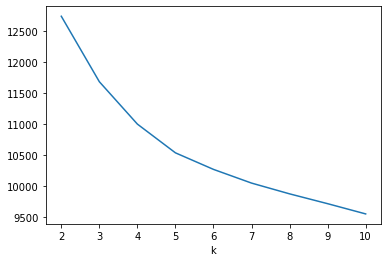

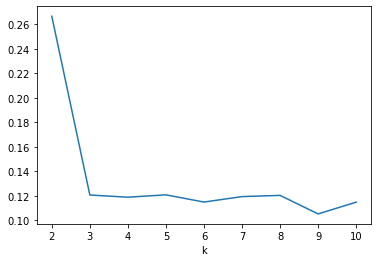

In [43]:
clustering_scores = []
for k in range(2, 11):
    clustering = sklearn.cluster.KMeans(n_clusters=k).fit(new_df)
    clustering_scores.append({
        'k': k,
        'sse': clustering.inertia_,
        'silhouette': sklearn.metrics.silhouette_score(new_df, clustering.labels_)
    })
df_clustering_scores = pd.DataFrame.from_dict(clustering_scores, orient='columns')
df_clustering_scores = df_clustering_scores.set_index('k')
df_clustering_scores.sse.plot()
plt.figure()
df_clustering_scores.silhouette.plot()

Podle grafu se přímka láme při k = 3 tedy použítu 3 pro K-means

In [44]:
clustering = sklearn.cluster.KMeans(n_clusters=3, random_state = 10)
clustering.fit(new_df)

KMeans(n_clusters=3, random_state=10)

In [45]:
pd.Series(clustering.labels_).value_counts()

0    1385
2     408
1     199
dtype: int64

Na první pohled jde vidět, že shluky jsou nevyvážené. Může to být způsobené plotovým rozdílem mezi hráči protože ten se mezi nimi lišil drasticky.

In [46]:
df['cluster_id'] = clustering.labels_
df

Age  Height  Weight          Nationality  Overall  ...  LBRating  \
ID                                                         ...             
183774   31     188      78              England       72  ...        62   
230249   25     189      84               Brazil       70  ...        65   
236527   24     177      77            Argentina       74  ...        70   
262732   19     194      77               Norway       60  ...        43   
245455   22     166      59         Saudi Arabia       52  ...        43   
...     ...     ...     ...                  ...      ...  ...       ...   
264450   21     178      74              Nigeria       68  ...        52   
257303   23     191      84          Netherlands       65  ...        63   
256415   18     182      70  Republic of Ireland       49  ...        41   
258749   17     188      78              England       55  ...        39   
261656   29     185      85        United States       56  ...        24   

        CBRating  RBRating  GKRating cluster_id  
ID                                               
183774        72        62        19          2  
230249        70        65        21          0  
236527        73        70        19          0  
262732        41        43        17          0  
245455        40        43        18          0  
...          ...       ...       ...        ...  
264450        48        52        19          0  
257303        67        63        18          2  
256415        37        41        14          0  
258749        34        39        15          0  
261656        25        24        57          1  

[1992 rows x 85 columns]

In [47]:
with pd.option_context('display.max_columns', None):
    display(df.groupby('cluster_id').describe())

Age                                                     Height  \
             count       mean       std   min   25%   50%   75%   max   count   
cluster_id                                                                      
0           1385.0  25.025993  4.595885  16.0  21.0  24.0  28.0  39.0  1385.0   
1            199.0  26.155779  5.344766  17.0  21.0  26.0  31.0  37.0   199.0   
2            408.0  25.026961  4.792681  17.0  21.0  24.0  29.0  39.0   408.0   

                                                                     Weight  \
                  mean       std    min    25%    50%    75%    max   count   
cluster_id                                                                    
0           178.884477  6.285794  163.0  175.0  179.0  183.0  202.0  1385.0   
1           188.361809  4.816821  176.0  185.0  188.0  192.0  201.0   199.0   
2           185.507353  5.106718  164.0  182.0  185.0  189.0  200.0   408.0   

                                                              Overall  \
                 mean       std   min   25%   50%   75%   max   count   
cluster_id                                                              
0           72.599278  6.531084  53.0  68.0  72.0  77.0  98.0  1385.0   
1           81.276382  6.323676  65.0  78.0  81.0  85.0  97.0   199.0   
2           77.946078  5.798588  59.0  75.0  78.0  82.0  93.0   408.0   

                                                              Potential  \
                 mean       std   min   25%   50%   75%   max     count   
cluster_id                                                                
0           66.374729  6.827378  48.0  62.0  66.0  71.0  91.0    1385.0   
1           64.402010  7.207543  51.0  59.0  64.0  69.0  89.0     199.0   
2           64.588235  6.599610  48.0  60.0  65.0  69.0  87.0     408.0   

                                                               Growth  \
                 mean       std   min   25%   50%   75%   max   count   
cluster_id                                                              
0           71.620217  6.275597  53.0  67.0  71.0  76.0  95.0  1385.0   
1           69.829146  6.307039  56.0  66.0  70.0  74.0  90.0   199.0   
2           70.424020  5.966665  52.0  67.0  70.0  74.0  90.0   408.0   

                                                          TotalStats  \
                mean       std  min  25%  50%   75%   max      count   
cluster_id                                                             
0           5.245487  5.440730  0.0  0.0  4.0   9.0  22.0     1385.0   
1           5.427136  5.972451  0.0  0.0  3.0  10.0  26.0      199.0   
2           5.835784  5.642067  0.0  0.0  5.0   9.0  23.0      408.0   

                                                                             \
                   mean         std     min     25%     50%     75%     max   
cluster_id                                                                    
0           1710.719856  189.525864  1187.0  1568.0  1712.0  1842.0  2304.0   
1           1047.125628  138.843962   793.0   930.0  1048.0  1157.0  1393.0   
2           1521.360294  168.333558  1133.0  1401.5  1513.5  1626.0  2074.0   

           BaseStats                                                     \
               count        mean        std    min    25%    50%    75%   
cluster_id                                                                
0             1385.0  365.683032  37.966842  258.0  339.0  366.0  392.0   
1              199.0  354.819095  40.347574  277.0  325.0  349.0  383.0   
2              408.0  328.411765  35.934175  238.0  302.0  328.0  351.0   

                  ValueEUR                                                 \
              max    count          mean           std      min       25%   
cluster_id                                                                  
0           485.0   1385.0  3.498155e+06  9.555869e+06  60000.0  550000.0   
1           486.0    199.0  1.922990e+06  6.751035e+06  3

In [48]:
with pd.option_context('display.max_columns', None):
    display(df)

Age  Height  Weight          Nationality  Overall  Potential  Growth  \
ID                                                                             
183774   31     188      78              England       72         72       0   
230249   25     189      84               Brazil       70         70       0   
236527   24     177      77            Argentina       74         80       6   
262732   19     194      77               Norway       60         75      15   
245455   22     166      59         Saudi Arabia       52         62      10   
...     ...     ...     ...                  ...      ...        ...     ...   
264450   21     178      74              Nigeria       68         78      10   
257303   23     191      84          Netherlands       65         73       8   
256415   18     182      70  Republic of Ireland       49         62      13   
258749   17     188      78              England       55         75      20   
261656   29     185      85        United States       56         58       2   

        TotalStats  BaseStats  Positions BestPosition               Club  \
ID                                                                         
183774        1367        288         CB           CB       Swansea City   
230249        1662        356     CDM,CB          CDM          Fortaleza   
236527        1888        405  CDM,CM,CB          CDM    Vélez Sarsfield   
262732        1462        320         ST           ST      FK Bodø/Glimt   
245455        1397        284         ST           ST           Al Batin   
...            ...        ...        ...          ...                ...   
264450        1726        372         RW           ST    Portimonense SC   
257303        1521        335         CB           CB       Lincoln City   
256415        1289        269      RM,LM          CAM         Derry City   
258749        1411        311      ST,RM           ST  Colchester United   
261656        1012        301         GK           GK   New York City FC   

        ValueEUR  WageEUR  ReleaseClause ClubPosition  ContractUntil  \
ID                                                                     
183774   1600000    19000        3000000           CB         2023.0   
230249   1600000     7000        3000000          CDM         2024.0   
236527   6000000    20000              0           CM         2021.0   
262732    600000      650        1100000          SUB         2024.0   
245455    180000     2000         333000          RES         2024.0   
...          ...      ...            ...          ...            ...   
264450   2700000     3000        6200000          SUB         2025.0   
257303   1500000     3000        2900000           CB         2023.0   
256415    110000      500         239000          RES         2021.0   
258749    350000      550         963000          SUB         2022.0   
261656    120000     1000         189000          RES         2021.0   

        ClubNumber  ClubJoined  OnLoad NationalTeam  PreferredFoot  \
ID                                                                   
183774         2.0        2020     0.0  Not in team            1.0   
230249        33.0        2021     0.0  Not in team            1.0   
236527        35.0        2018     1.0  Not in team            1.0   
262732        24.0        2021     0.0  Not in team            0.0   
245455        15.0        2018     0.0  Not in team            1.0   
...            ...         ...     ...          ...            ...   
264450        99.0        2021     0.0  Not in team            0.0   
257303         4.0        2020     0.0  Not in team            1.0   
256415        28.0        2020     0.0  Not in team            1.0   
258749        34.0        2020     0.0  Not in team            0.0   
261656        25.0        2021     0.0  Not in team            1.0   

        IntReputation  WeakFoot  SkillMoves  AttackingWorkRate  \
ID                                                              

In [49]:
with pd.option_context('display.max_columns', None):
    display(df.groupby('cluster_id').describe(include='O'))

Nationality                      Positions                  \
                 count unique      top freq     count unique top freq   
cluster_id                                                              
0                 1385     98  England  120      1385    254  ST  193   
1                  199     52  England   19       199      1  GK  199   
2                  408     69  England   56       408     37  CB  244   

           BestPosition                  Club                              \
                  count unique top freq count unique                  top   
cluster_id                                                                  
0                  1385     14  ST  277  1385    598   Real Valladolid CF   
1                   199      1  GK  199   199    182      Kashima Antlers   
2                   408      5  CB  378   408    303  Peterborough United   

                ClubPosition                  NationalTeam         \
           freq        count unique  top freq        count unique   
cluster_id                                                          
0             7         1385     18  SUB  626         1385     29   
1             2          199      3  SUB   85          199      7   
2             4          408      8  SUB  154          408     11   

                               
                    top  freq  
cluster_id                     
0           Not in team  1320  
1           Not in team   193  
2           Not in team   397

<AxesSubplot:xlabel='cluster_id', ylabel='Age'>

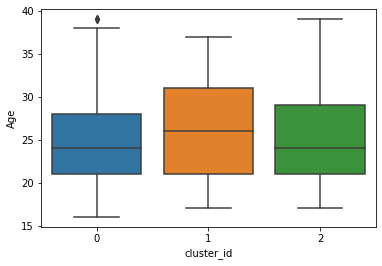

In [50]:
sns.boxplot(data = df, y = 'Age', x='cluster_id')


Cluster 0 obsahuje nejstarší hráče ale cluster 1 obsahuje jednoho outliara s druhým nejvíce starými hráči. 

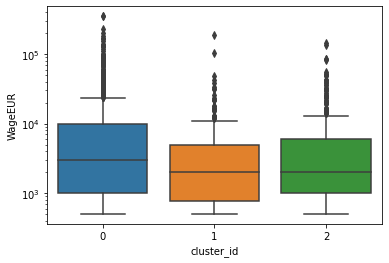

In [51]:
sns.boxplot(data = df, y = 'WageEUR', x='cluster_id')
plt.yscale("log")

Jelikož mezi platovými třídy je velká propast, musel jsem změnit měřítko grafu na logaritmické. Cluster 1 obsahuje nejlépe placené hráče.

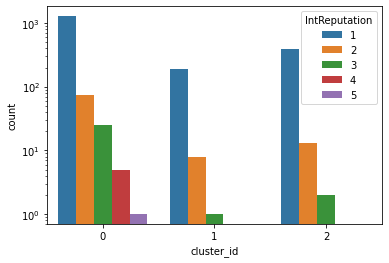

In [52]:
sns.countplot(data = df, hue = 'IntReputation', x='cluster_id')
plt.yscale("log")

Hráči měli clusteru 1 nejvíce hráču celkově, proto tam je nejvíce hráčů s reputací 1 tedy nejnižší. Tento cluster obsahuje taky pár hráčů s reputací 5 tedy nejvyšší. 

In [53]:
df

Age  Height  Weight          Nationality  Overall  ...  LBRating  \
ID                                                         ...             
183774   31     188      78              England       72  ...        62   
230249   25     189      84               Brazil       70  ...        65   
236527   24     177      77            Argentina       74  ...        70   
262732   19     194      77               Norway       60  ...        43   
245455   22     166      59         Saudi Arabia       52  ...        43   
...     ...     ...     ...                  ...      ...  ...       ...   
264450   21     178      74              Nigeria       68  ...        52   
257303   23     191      84          Netherlands       65  ...        63   
256415   18     182      70  Republic of Ireland       49  ...        41   
258749   17     188      78              England       55  ...        39   
261656   29     185      85        United States       56  ...        24   

        CBRating  RBRating  GKRating cluster_id  
ID                                               
183774        72        62        19          2  
230249        70        65        21          0  
236527        73        70        19          0  
262732        41        43        17          0  
245455        40        43        18          0  
...          ...       ...       ...        ...  
264450        48        52        19          0  
257303        67        63        18          2  
256415        37        41        14          0  
258749        34        39        15          0  
261656        25        24        57          1  

[1992 rows x 85 columns]

In [68]:
df.columns

Index(['Age', 'Height', 'Weight', 'Nationality', 'Overall', 'Potential',
       'Growth', 'TotalStats', 'BaseStats', 'Positions', 'BestPosition',
       'Club', 'ValueEUR', 'WageEUR', 'ReleaseClause', 'ClubPosition',
       'ContractUntil', 'ClubNumber', 'ClubJoined', 'OnLoad', 'NationalTeam',
       'PreferredFoot', 'IntReputation', 'WeakFoot', 'SkillMoves',
       'AttackingWorkRate', 'DefensiveWorkRate', 'PaceTotal', 'ShootingTotal',
       'PassingTotal', 'DribblingTotal', 'DefendingTotal', 'PhysicalityTotal',
       'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys',
       'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
       'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance',
       'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
       'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
       'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving',
       'GKHandling', 'GKKicking', '

<ipython-input-106-16b473ba4af3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_numeric['cluster_id'] = df['cluster_id']


Nationality


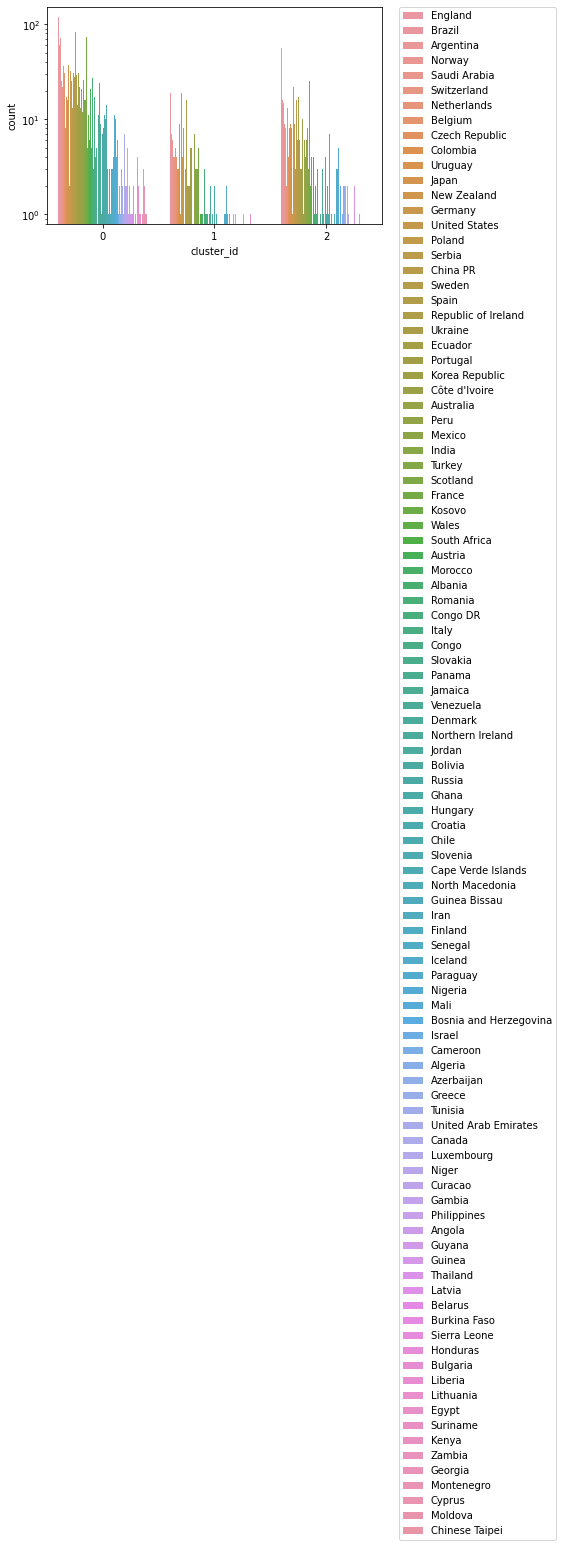

Positions


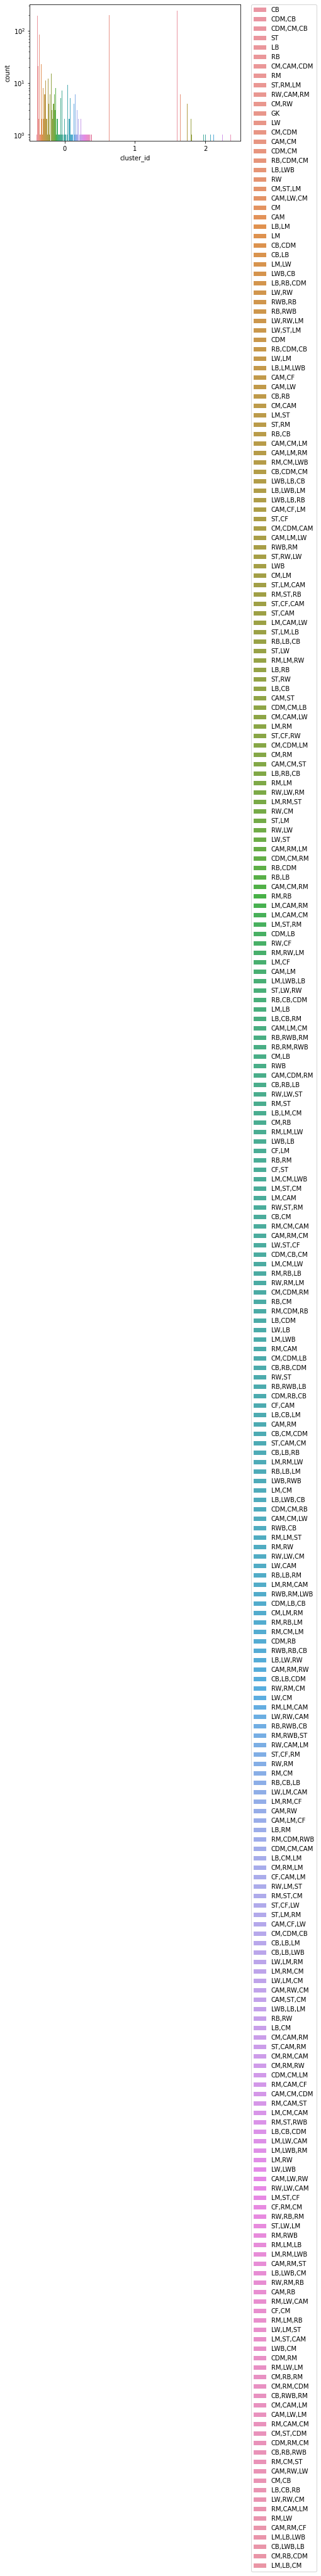

BestPosition


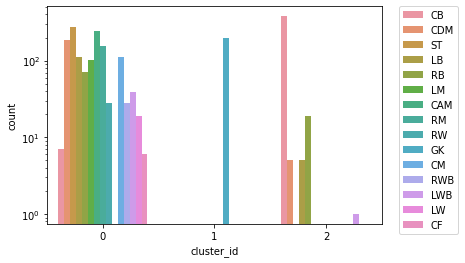

Club


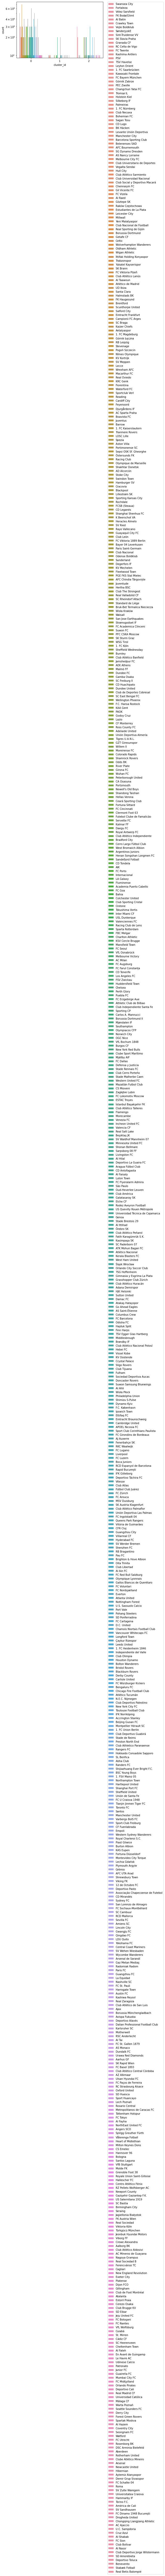

ClubPosition


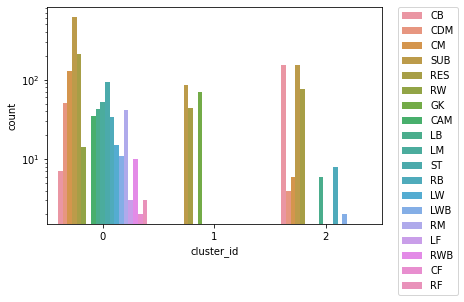

NationalTeam


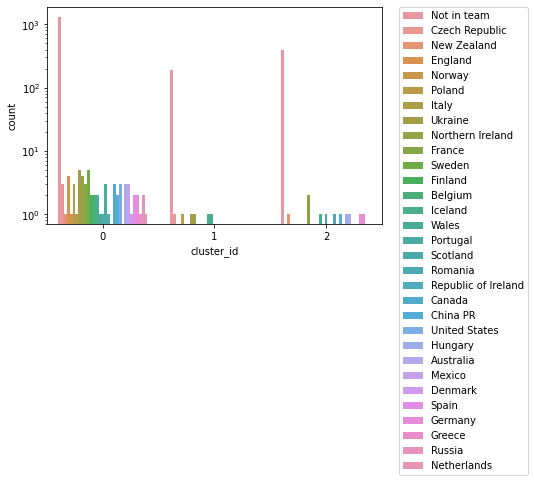

cluster_id


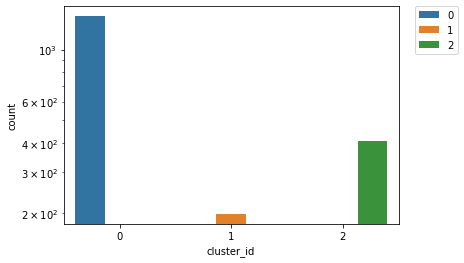

In [106]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_non_numeric = df.select_dtypes(exclude=numerics)
df_non_numeric['cluster_id'] = df['cluster_id']
for col in df_non_numeric.columns:
    print(col)
    sns.countplot(data = df_non_numeric, hue = col, x='cluster_id')
    plt.yscale("log")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.show()

Jak jde vidět z grafů nenumerických atributů, dělat jejich countploty nemá moc smysl, jelikož většina slouců obsahuje hodně různých hodnot, tak barevné rozlišení není pro lidské oko dobré, hodnoty splívají. Ale i tak se z toho dá pár informací vypozorovat. Například, že většina hráčů nebyla v týmu. BestPosition v shluku 0 i přesto, že má početně největší zastoupení neobsahuje žádné GK zatímco shluk 1 obsahuje právě tohle BestPosition. Shluk 2 obsahuje Nejpočetněji BestPosition CB.    

In [109]:
df.groupby('cluster_id').BestPosition.value_counts()

cluster_id  BestPosition
0           ST              277
            CAM             242
            CDM             184
            RM              155
            CM              113
            LB              113
            LM              102
            RB               72
            LWB              39
            RW               28
            RWB              28
            LW               19
            CB                7
            CF                6
1           GK              199
2           CB              378
            RB               19
            CDM               5
            LB                5
            LWB               1
Name: BestPosition, dtype: int64

In [114]:
with pd.option_context('display.max_rows', None):
    display(df.groupby('cluster_id').Nationality.value_counts())

cluster_id  Nationality           
0           England                   120
            Spain                      82
            Germany                    81
            France                     73
            Argentina                  71
            Brazil                     60
            Japan                      37
            Netherlands                36
            United States              32
            Belgium                    31
            China PR                   31
            Portugal                   31
            Republic of Ireland        29
            Sweden                     28
            Romania                    27
            Mexico                     26
            Norway                     25
            Poland                     25
            Denmark                    24
            Korea Republic             22
            Saudi Arabia               22
            Australia                  21
            Austria                    21

Většina lidí napříč shluky pochází z anglie.

Age


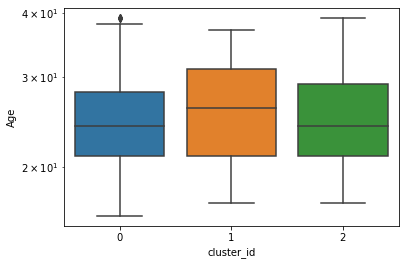

Height


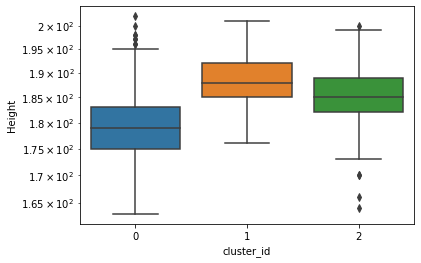

Weight


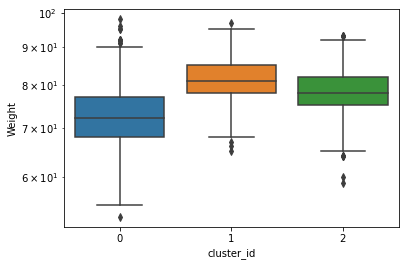

Overall


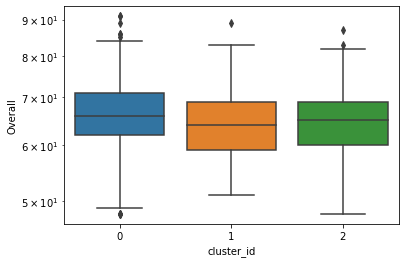

Potential


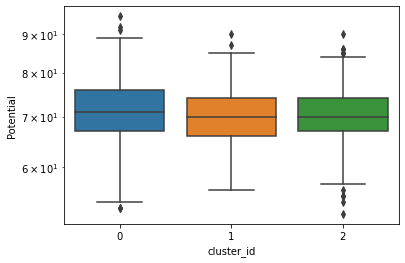

Growth


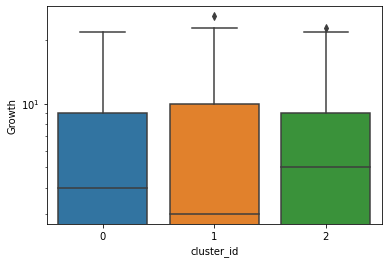

TotalStats


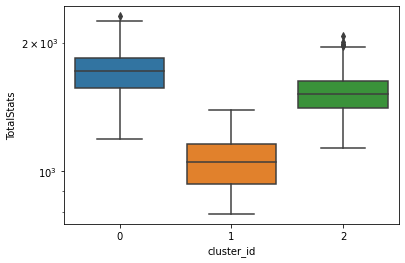

BaseStats


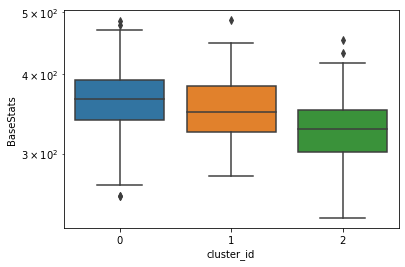

ValueEUR


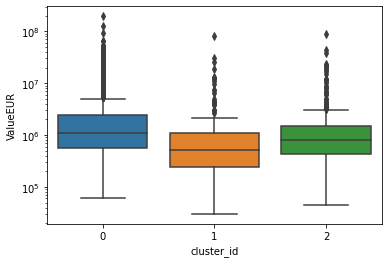

WageEUR


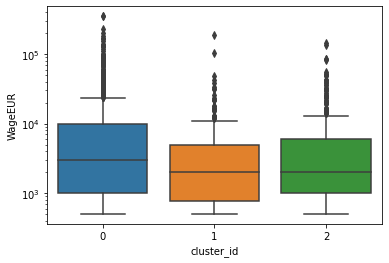

ReleaseClause


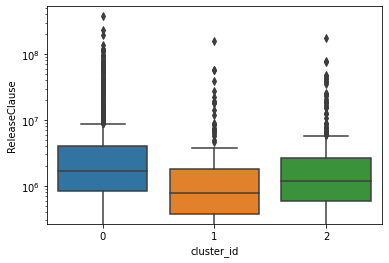

ContractUntil


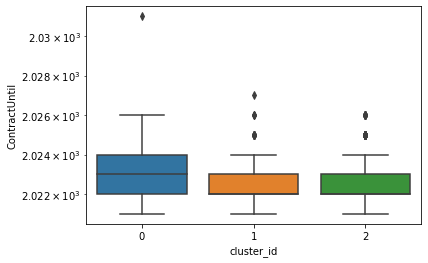

ClubNumber


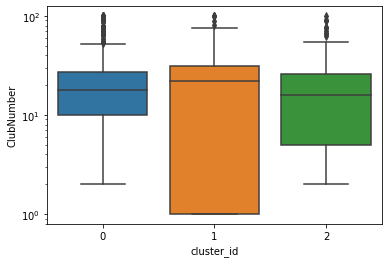

ClubJoined


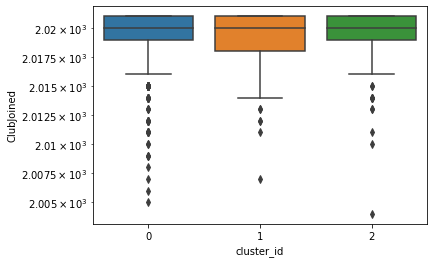

OnLoad


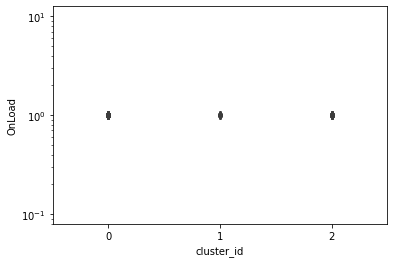

PreferredFoot


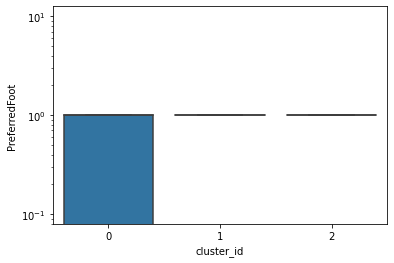

IntReputation


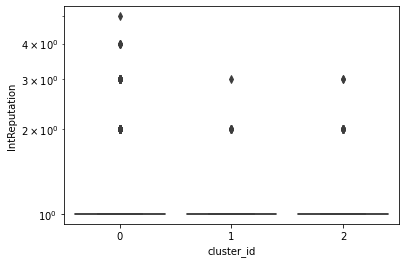

WeakFoot


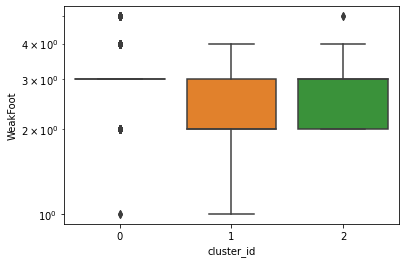

SkillMoves


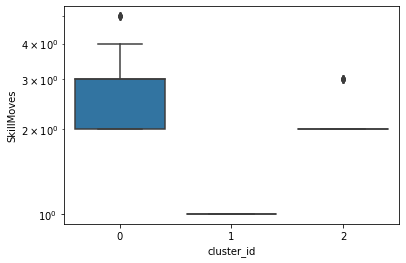

AttackingWorkRate


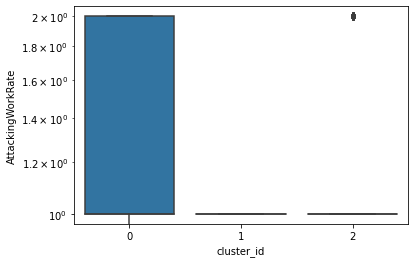

DefensiveWorkRate


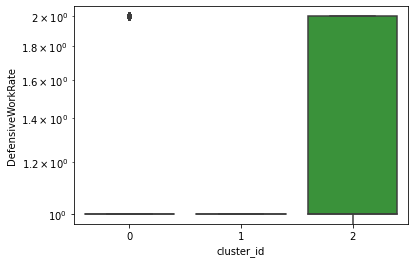

PaceTotal


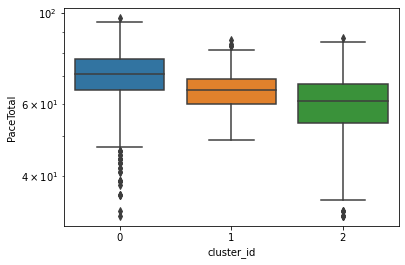

ShootingTotal


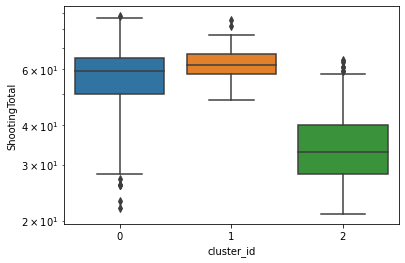

PassingTotal


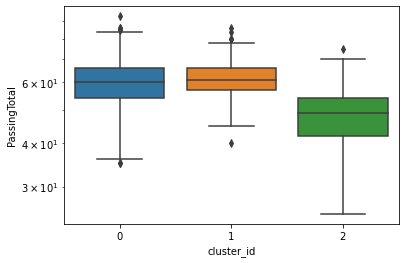

DribblingTotal


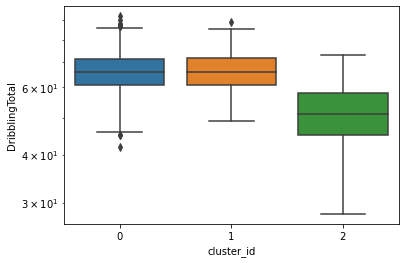

DefendingTotal


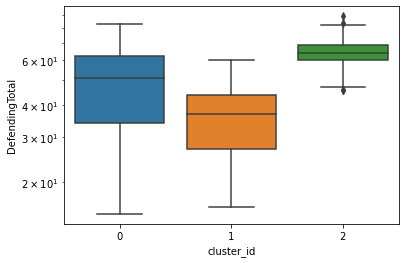

PhysicalityTotal


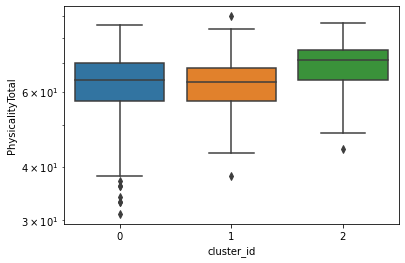

Crossing


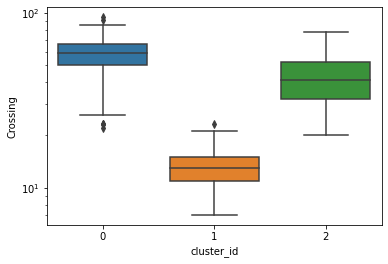

Finishing


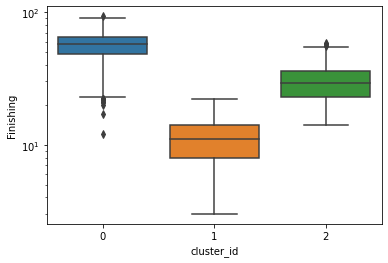

HeadingAccuracy


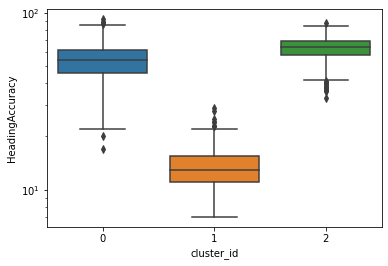

ShortPassing


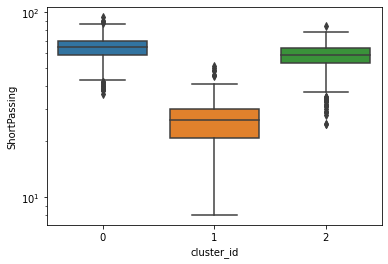

Volleys


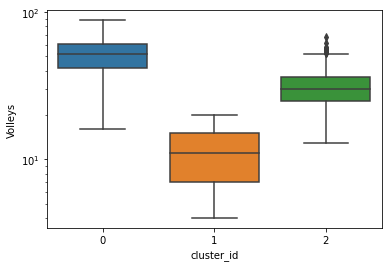

Dribbling


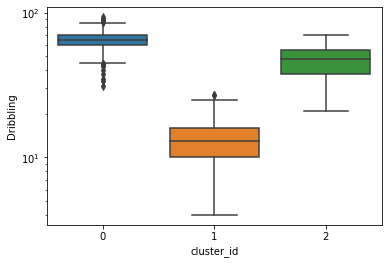

Curve


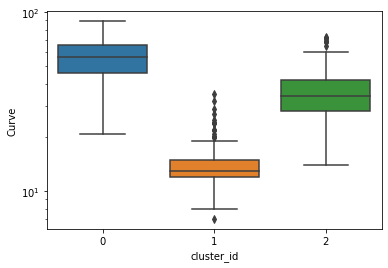

FKAccuracy


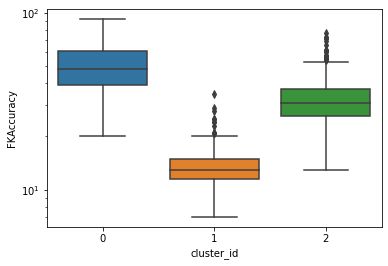

LongPassing


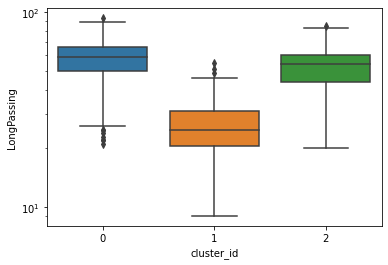

BallControl


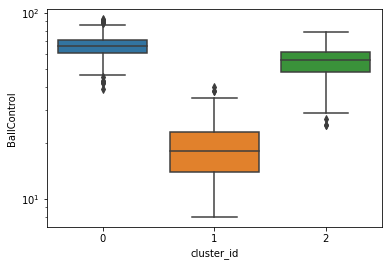

Acceleration


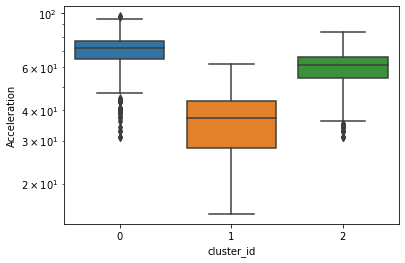

SprintSpeed


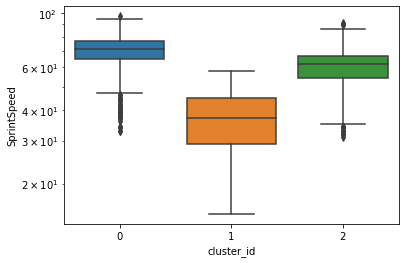

Agility


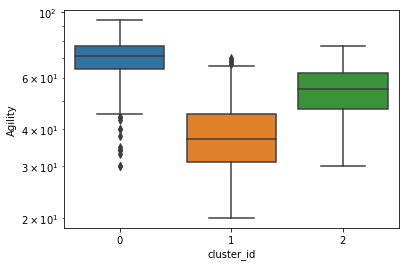

Reactions


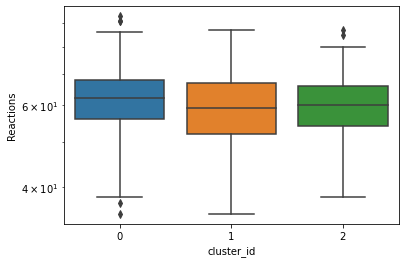

Balance


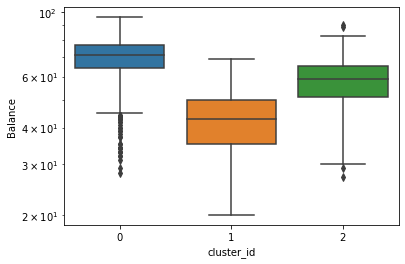

ShotPower


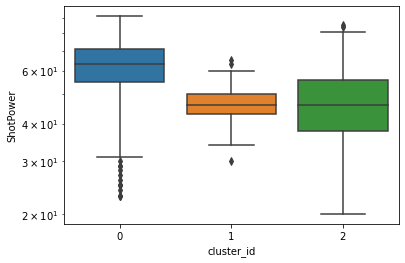

Jumping


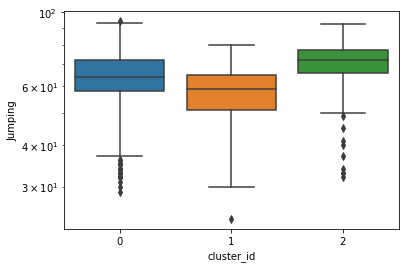

Stamina


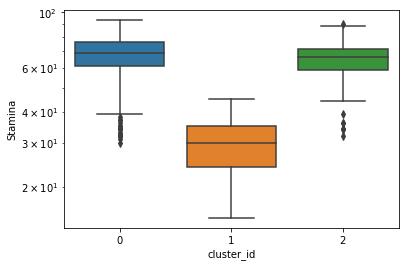

Strength


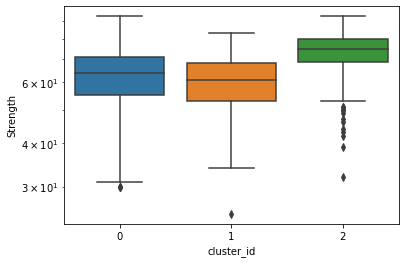

LongShots


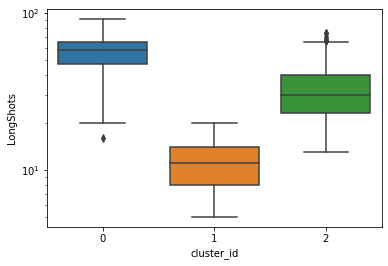

Aggression


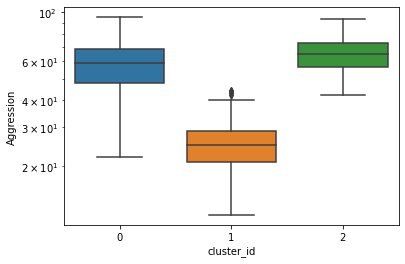

Interceptions


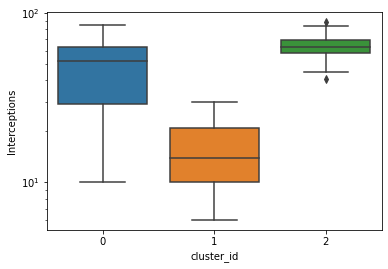

Positioning


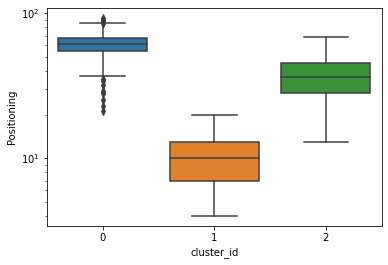

Vision


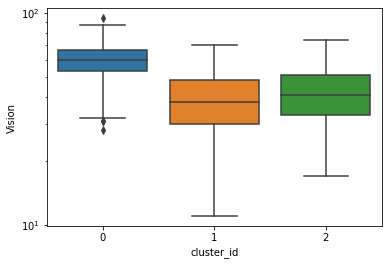

Penalties


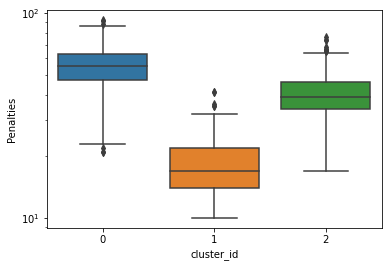

Composure


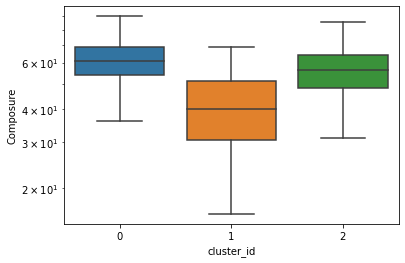

Marking


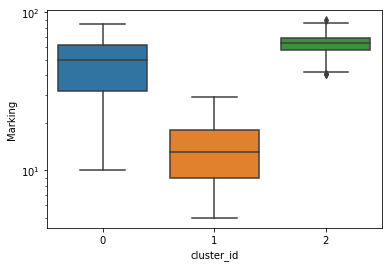

StandingTackle


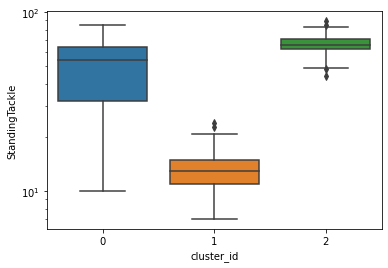

SlidingTackle


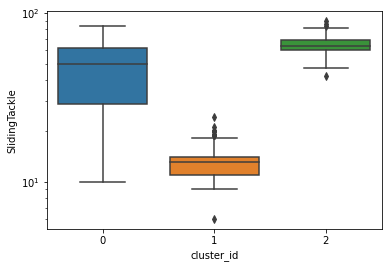

GKDiving


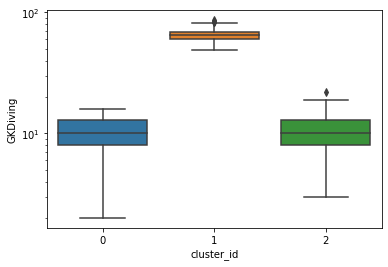

GKHandling


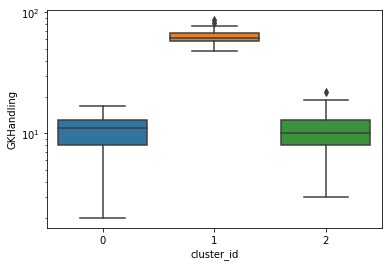

GKKicking


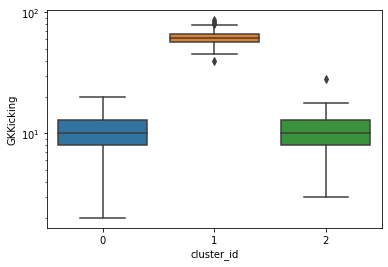

GKPositioning


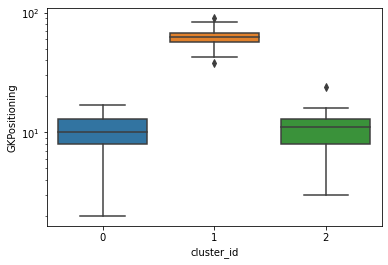

GKReflexes


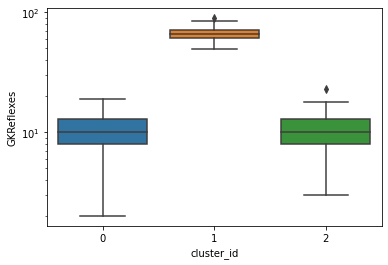

STRating


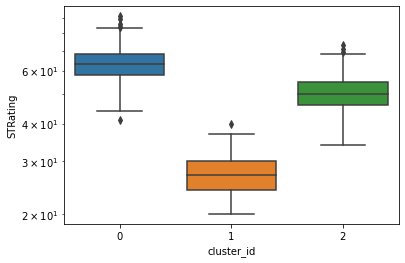

LWRating


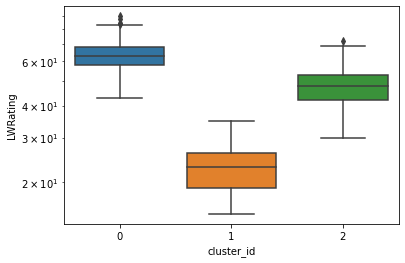

LFRating


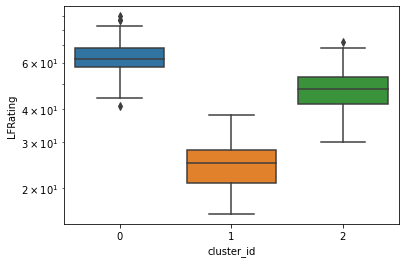

CFRating


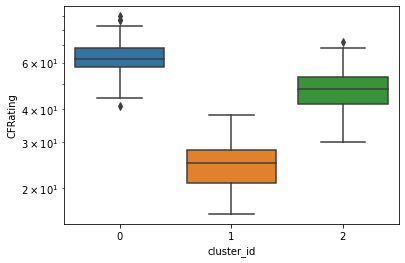

RFRating


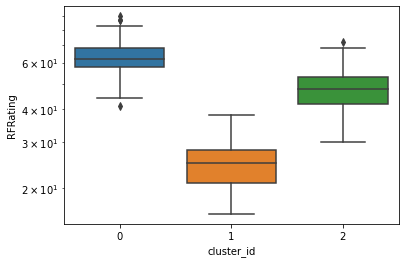

RWRating


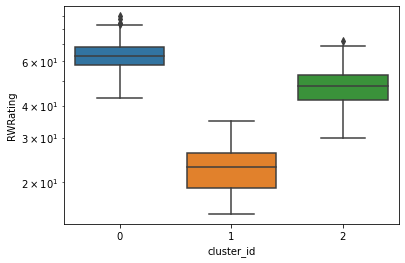

CAMRating


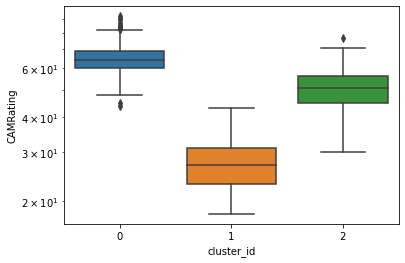

LMRating


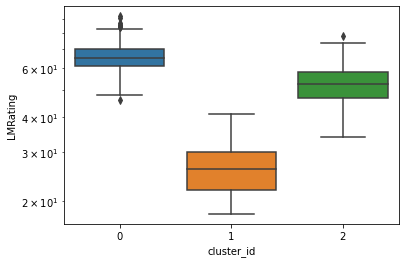

CMRating


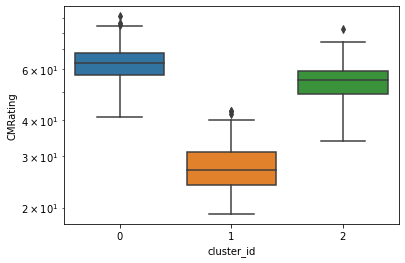

RMRating


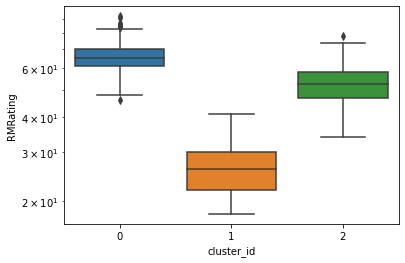

LWBRating


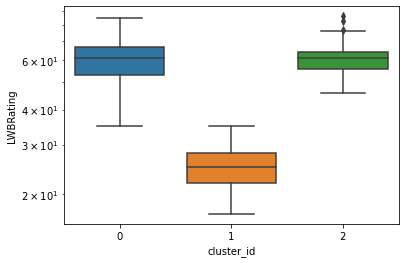

CDMRating


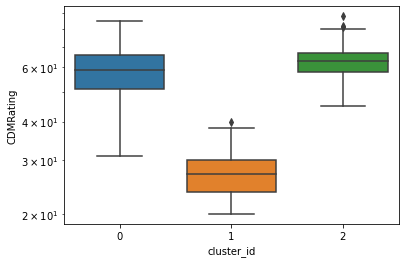

RWBRating


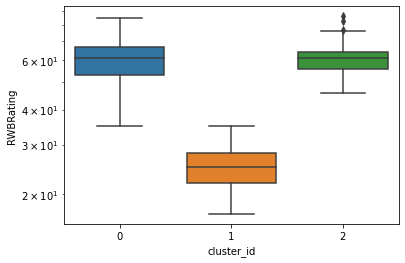

LBRating


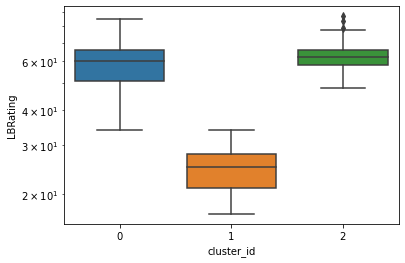

CBRating


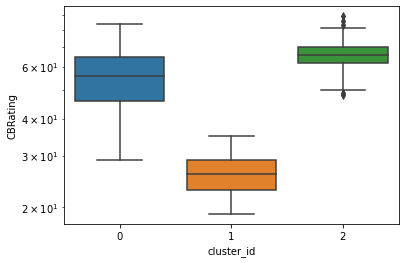

RBRating


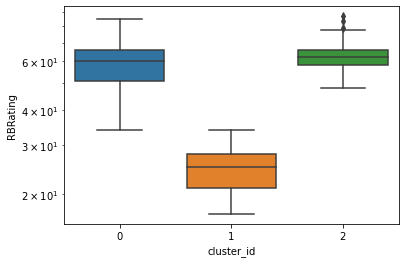

GKRating


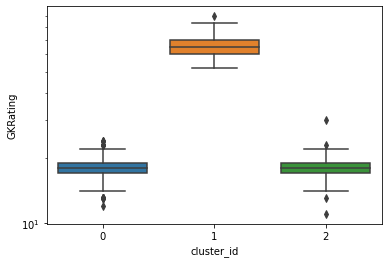

cluster_id


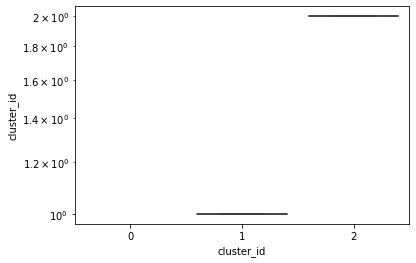

In [115]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_numeric = df.select_dtypes(include=numerics)

for col in df_numeric.columns:
    print(col)
    sns.boxplot(data = df_numeric, y = col, x='cluster_id')  
    plt.yscale("log")
    plt.show()

Boxploty numerický atributů vyšly vyzuálně lépe než grafy nenumerických. Jelikož dataframe obsahuje hodně sloupců, tak popíšu jen některé z nich.

Z grafu 'Age' jde vidět, že shluk 1 má největší rozptyl a střední hodnotu ale shluk 0 mám jednoho outlayera. 

Z grafu 'Height' můžeme vypozorovat, že shluk 1 má největší přůměrnou výšku. Shluk 0 má outlayery s maximální hodnotou přes 2 metry. A shluk 2 má outlayery s minemem 1,65 metrů. 

'Weight' shluk 0 má opět největší průmernou hodnotu shluk 0 má největší rozptyl s outlayery na obou koncích.

'Overall' shluk 0 má největší střední hodnotu. Shhluky 1 a 2 jsou si podobné.

'Potential' shluky jsou si velice podobné až na outlayery.

'Growth' všechny shluky mají podobný rozptyl ale jejich průměrná hodnat se výrazně liší.

'TotalStats' shluk 0 má největší průměrnou hodnotu poněm shluk 2 a pak 1

'ValueEUR' největší hodnotu mají hráči shluku 0 po něm 2 a pak 1. Všechny shluky obsahují hodně outlayerů. Nejspíš se jedná o fotbalové hvězdy (Ronaldo, Messi atd.)

'WageEUR' hráči shluku 0 jsou nejlépe placení. Vidíme, že v každém shluku je veliký rozdím mezi platovými třídy.

'SkillMoves' shluk 0 obshuje nejtalentovanější hráče

'AttackingWorkRate' shluk 0 obsahuje nejvíce útočných hráčů, zatímco ostatní ne tak moc spíš zřídka, a když už tak je to outlayer

'DefensiveWorkRate' shluk 2 obsahuje nejvíce hráčů co hrajou obranu

In [123]:
with pd.option_context('display.max_columns', None):
    display(df.groupby('cluster_id').describe())

Age                                                     Height  \
             count       mean       std   min   25%   50%   75%   max   count   
cluster_id                                                                      
0           1385.0  25.025993  4.595885  16.0  21.0  24.0  28.0  39.0  1385.0   
1            199.0  26.155779  5.344766  17.0  21.0  26.0  31.0  37.0   199.0   
2            408.0  25.026961  4.792681  17.0  21.0  24.0  29.0  39.0   408.0   

                                                                     Weight  \
                  mean       std    min    25%    50%    75%    max   count   
cluster_id                                                                    
0           178.884477  6.285794  163.0  175.0  179.0  183.0  202.0  1385.0   
1           188.361809  4.816821  176.0  185.0  188.0  192.0  201.0   199.0   
2           185.507353  5.106718  164.0  182.0  185.0  189.0  200.0   408.0   

                                                              Overall  \
                 mean       std   min   25%   50%   75%   max   count   
cluster_id                                                              
0           72.599278  6.531084  53.0  68.0  72.0  77.0  98.0  1385.0   
1           81.276382  6.323676  65.0  78.0  81.0  85.0  97.0   199.0   
2           77.946078  5.798588  59.0  75.0  78.0  82.0  93.0   408.0   

                                                              Potential  \
                 mean       std   min   25%   50%   75%   max     count   
cluster_id                                                                
0           66.374729  6.827378  48.0  62.0  66.0  71.0  91.0    1385.0   
1           64.402010  7.207543  51.0  59.0  64.0  69.0  89.0     199.0   
2           64.588235  6.599610  48.0  60.0  65.0  69.0  87.0     408.0   

                                                               Growth  \
                 mean       std   min   25%   50%   75%   max   count   
cluster_id                                                              
0           71.620217  6.275597  53.0  67.0  71.0  76.0  95.0  1385.0   
1           69.829146  6.307039  56.0  66.0  70.0  74.0  90.0   199.0   
2           70.424020  5.966665  52.0  67.0  70.0  74.0  90.0   408.0   

                                                          TotalStats  \
                mean       std  min  25%  50%   75%   max      count   
cluster_id                                                             
0           5.245487  5.440730  0.0  0.0  4.0   9.0  22.0     1385.0   
1           5.427136  5.972451  0.0  0.0  3.0  10.0  26.0      199.0   
2           5.835784  5.642067  0.0  0.0  5.0   9.0  23.0      408.0   

                                                                             \
                   mean         std     min     25%     50%     75%     max   
cluster_id                                                                    
0           1710.719856  189.525864  1187.0  1568.0  1712.0  1842.0  2304.0   
1           1047.125628  138.843962   793.0   930.0  1048.0  1157.0  1393.0   
2           1521.360294  168.333558  1133.0  1401.5  1513.5  1626.0  2074.0   

           BaseStats                                                     \
               count        mean        std    min    25%    50%    75%   
cluster_id                                                                
0             1385.0  365.683032  37.966842  258.0  339.0  366.0  392.0   
1              199.0  354.819095  40.347574  277.0  325.0  349.0  383.0   
2              408.0  328.411765  35.934175  238.0  302.0  328.0  351.0   

                  ValueEUR                                                 \
              max    count          mean           std      min       25%   
cluster_id                                                                  
0           485.0   1385.0  3.498155e+06  9.555869e+06  60000.0  550000.0   
1           486.0    199.0  1.922990e+06  6.751035e+06  3

Pomocí fuknce describe si můžu zobrazi rozdíly shluků v numerické formě

Pro další část ůkolu použiju aglomerativní shlukování 


In [131]:
clustering = AgglomerativeClustering(linkage='single', distance_threshold=None, n_clusters=3)
clustering = clustering.fit(new_df)
pd.Series(clustering.labels_).value_counts()

2    1989
0       2
1       1
dtype: int64

Tohle rozdělení shluků není ideální, protože více méně všechny řádky by patříly do jednoho shluku. Poměním parametry algoritmu a pak se rozhodnu s čim bude pracovat.

In [132]:
clustering = AgglomerativeClustering(linkage='ward', distance_threshold=None, n_clusters=3)
clustering = clustering.fit(new_df)
pd.Series(clustering.labels_).value_counts()

0    1406
2     387
1     199
dtype: int64

‘ward’, ‘complete’, ‘average’, ‘single’

In [137]:
clustering = AgglomerativeClustering(linkage='complete', distance_threshold=None, n_clusters=3)
clustering = clustering.fit(new_df)
pd.Series(clustering.labels_).value_counts()

1    1042
0     751
2     199
dtype: int64

In [142]:
clustering = AgglomerativeClustering(linkage='average', distance_threshold=None, n_clusters=3)
clustering = clustering.fit(new_df)
pd.Series(clustering.labels_).value_counts()

0    1786
1     199
2       7
dtype: int64

Nejlepší mi příjde rozdělení shluků s parametrem linkage='complete' 

In [144]:
clustering = AgglomerativeClustering(linkage='complete', distance_threshold=None, n_clusters=3)
clustering = clustering.fit(new_df) # new_df  škálované
pd.Series(clustering.labels_).value_counts()

1    1042
0     751
2     199
dtype: int64

In [145]:
df['cluster_id'] = clustering.labels_
df

Age  Height  Weight          Nationality  Overall  ...  LBRating  \
ID                                                         ...             
183774   31     188      78              England       72  ...        62   
230249   25     189      84               Brazil       70  ...        65   
236527   24     177      77            Argentina       74  ...        70   
262732   19     194      77               Norway       60  ...        43   
245455   22     166      59         Saudi Arabia       52  ...        43   
...     ...     ...     ...                  ...      ...  ...       ...   
264450   21     178      74              Nigeria       68  ...        52   
257303   23     191      84          Netherlands       65  ...        63   
256415   18     182      70  Republic of Ireland       49  ...        41   
258749   17     188      78              England       55  ...        39   
261656   29     185      85        United States       56  ...        24   

        CBRating  RBRating  GKRating cluster_id  
ID                                               
183774        72        62        19          1  
230249        70        65        21          0  
236527        73        70        19          0  
262732        41        43        17          1  
245455        40        43        18          1  
...          ...       ...       ...        ...  
264450        48        52        19          1  
257303        67        63        18          1  
256415        37        41        14          1  
258749        34        39        15          1  
261656        25        24        57          2  

[1992 rows x 85 columns]

In [149]:
df.cluster_id.value_counts()

1    1042
0     751
2     199
Name: cluster_id, dtype: int64

In [150]:
with pd.option_context('display.max_columns', None):
    display(df.groupby('cluster_id').describe())

Age                                                      \
             count       mean       std   min   25%   50%    75%   max   
cluster_id                                                               
0            751.0  26.169108  4.365856  17.0  23.0  26.0  29.00  39.0   
1           1042.0  24.202495  4.659210  16.0  21.0  23.0  27.75  39.0   
2            199.0  26.155779  5.344766  17.0  21.0  26.0  31.00  37.0   

            Height                                                           \
             count        mean       std    min    25%    50%    75%    max   
cluster_id                                                                    
0            751.0  178.496671  5.824058  163.0  175.0  178.0  183.0  197.0   
1           1042.0  181.757198  6.863677  163.0  177.0  182.0  187.0  202.0   
2            199.0  188.361809  4.816821  176.0  185.0  188.0  192.0  201.0   

            Weight                                                    Overall  \
             count       mean       std   min   25%   50%   75%   max   count   
cluster_id                                                                      
0            751.0  72.348868  5.888814  53.0  68.0  72.0  76.0  95.0   751.0   
1           1042.0  74.873321  7.131217  55.0  70.0  75.0  80.0  98.0  1042.0   
2            199.0  81.276382  6.323676  65.0  78.0  81.0  85.0  97.0   199.0   

                                                              Potential  \
                 mean       std   min   25%   50%   75%   max     count   
cluster_id                                                                
0           69.242344  6.301100  51.0  65.0  69.0  73.0  91.0     751.0   
1           63.608445  6.168795  48.0  59.0  63.0  68.0  81.0    1042.0   
2           64.402010  7.207543  51.0  59.0  64.0  69.0  89.0     199.0   

                                                                Growth  \
                 mean       std   min    25%   50%   75%   max   count   
cluster_id                                                               
0           72.957390  6.429374  53.0  68.00  72.0  77.0  95.0   751.0   
1           70.188100  5.806447  52.0  66.25  70.0  74.0  86.0  1042.0   
2           69.829146  6.307039  56.0  66.00  70.0  74.0  90.0   199.0   

                                                          TotalStats  \
                mean       std  min  25%  50%   75%   max      count   
cluster_id                                                             
0           3.715047  4.538872  0.0  0.0  1.0   7.0  20.0      751.0   
1           6.579655  5.798563  0.0  0.0  6.0  11.0  23.0     1042.0   
2           5.427136  5.972451  0.0  0.0  3.0  10.0  26.0      199.0   

                                                                               \
                   mean         std     min      25%     50%      75%     max   
cluster_id                                                                      
0           1813.544607  160.024641  1348.0  1712.00  1808.0  1922.00  2304.0   
1           1562.466411  157.512683  1133.0  1457.25  1556.5  1674.75  2027.0   
2           1047.125628  138.843962   793.0   930.00  1048.0  1157.00  1393.0   

           BaseStats                                                     \
               count        mean        std    min    25%    50%    75%   
cluster_id                                                                
0              751.0  385.844208  31.707849  288.0  364.0  385.0  407.0   
1             1042.0  336.558541  33.152675  238.0  314.0  336.0  359.0   
2              199.0  354.819095  40.347574  277.0  325.0  349.0  383.0   

                  ValueEUR                                                 \
              max    count          mean           std      min       25%   
cluster_id                                                                  
0           485.0    751.0  5.552184e+06  1.305773e+07  60000.0  825000.0   
1           430.0   1042.0  1.458

Porovnám numerické atributy jednotlivých shluků.

Age


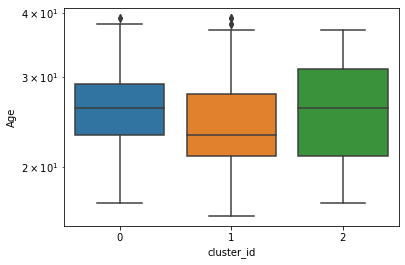

Height


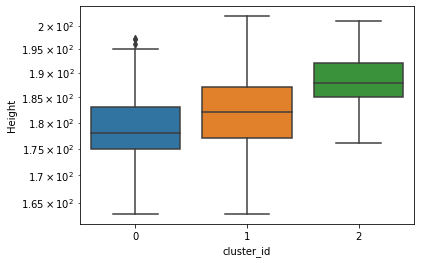

Weight


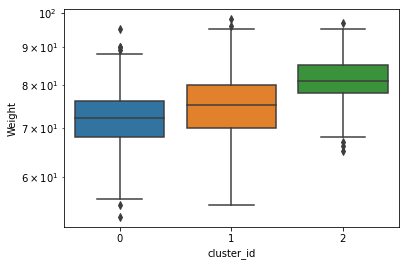

Overall


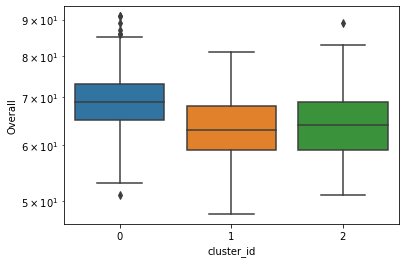

Potential


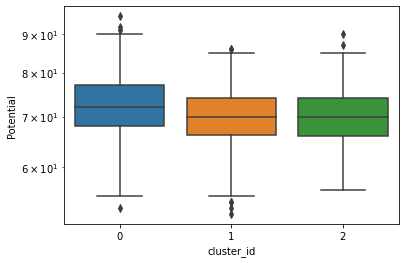

Growth


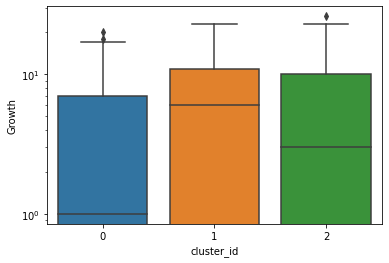

TotalStats


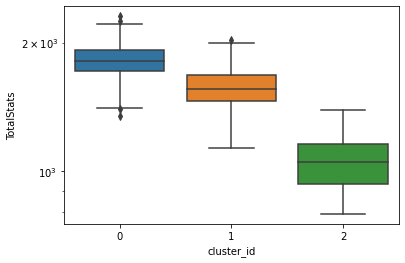

BaseStats


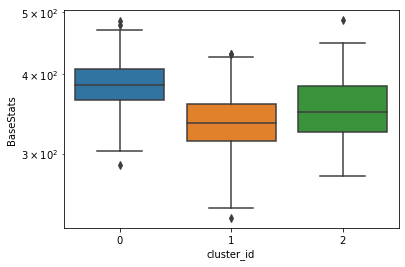

ValueEUR


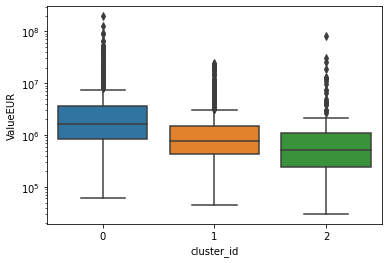

WageEUR


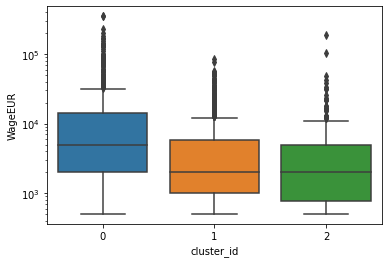

ReleaseClause


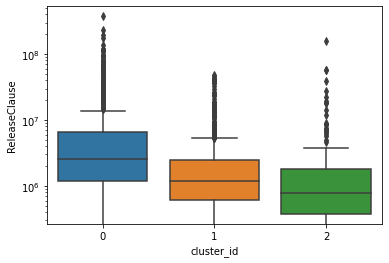

ContractUntil


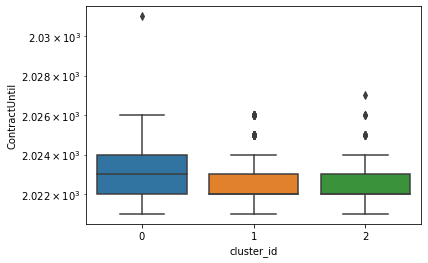

ClubNumber


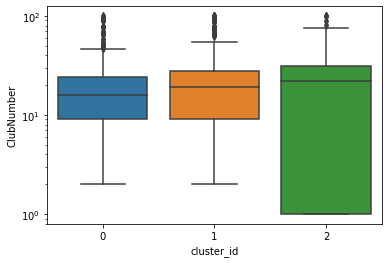

ClubJoined


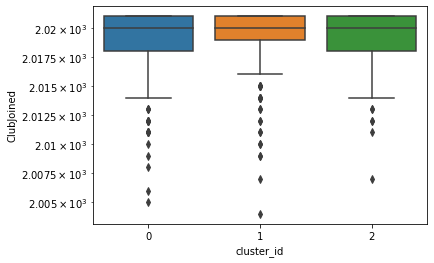

OnLoad


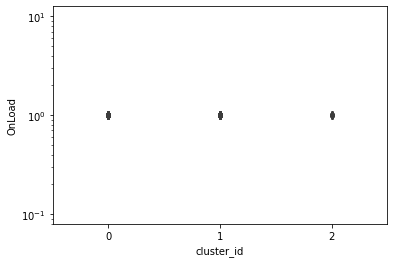

PreferredFoot


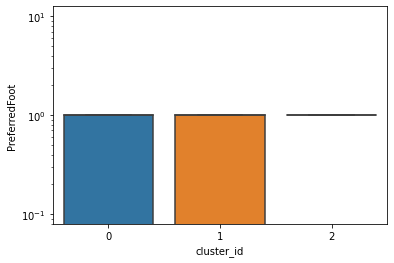

IntReputation


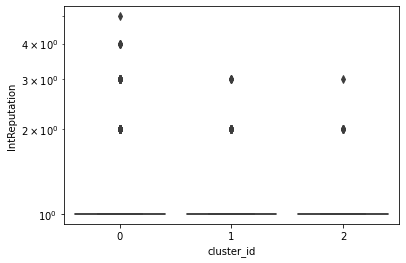

WeakFoot


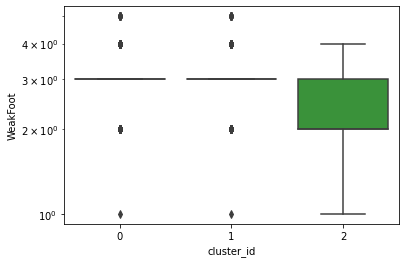

SkillMoves


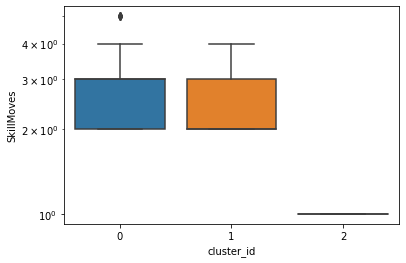

AttackingWorkRate


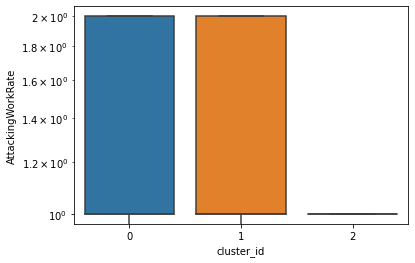

DefensiveWorkRate


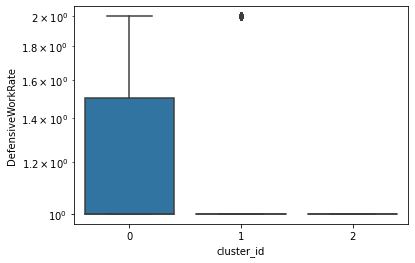

PaceTotal


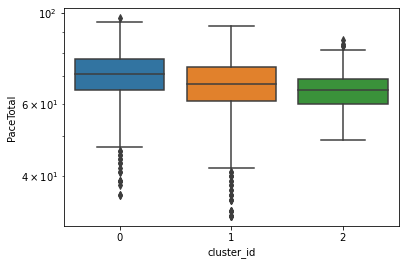

ShootingTotal


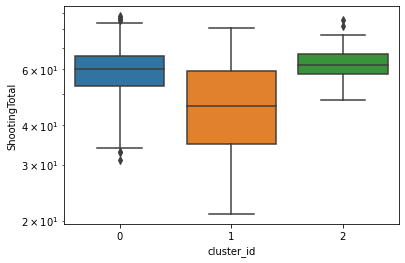

PassingTotal


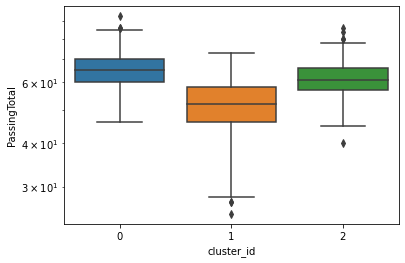

DribblingTotal


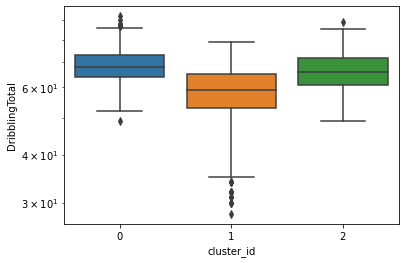

DefendingTotal


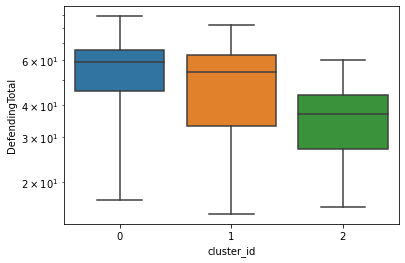

PhysicalityTotal


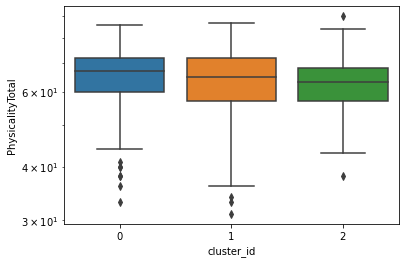

Crossing


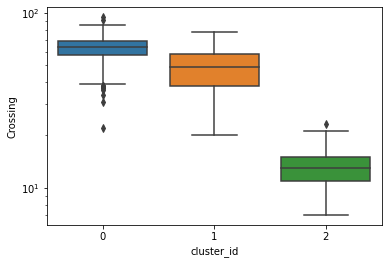

Finishing


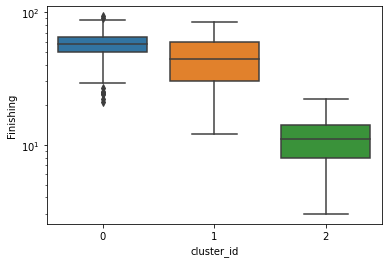

HeadingAccuracy


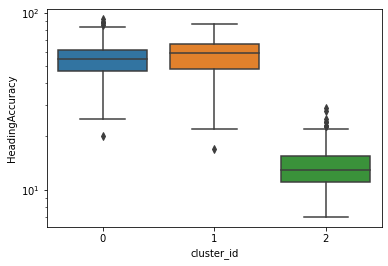

ShortPassing


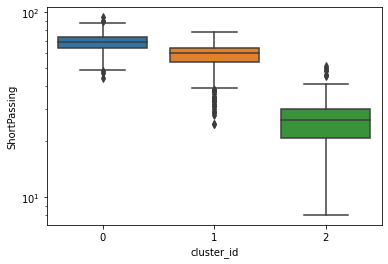

Volleys


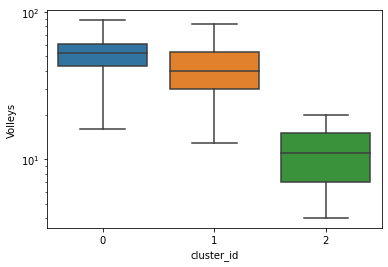

Dribbling


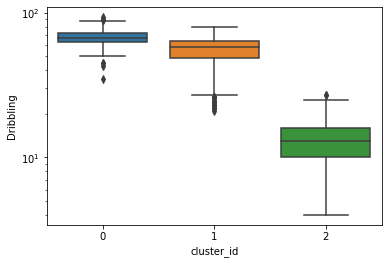

Curve


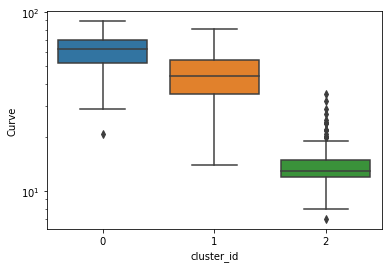

FKAccuracy


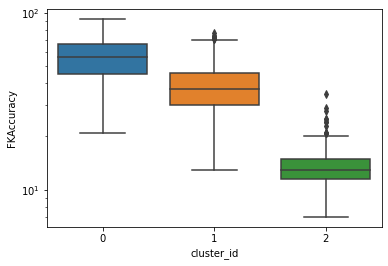

LongPassing


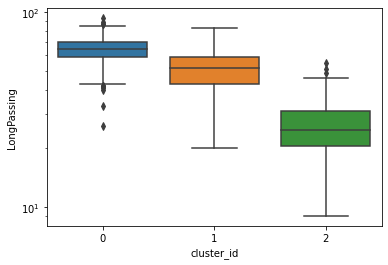

BallControl


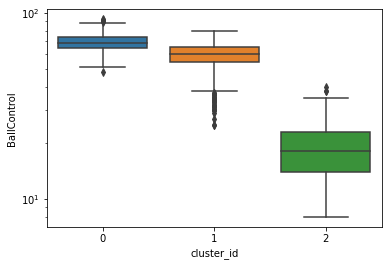

Acceleration


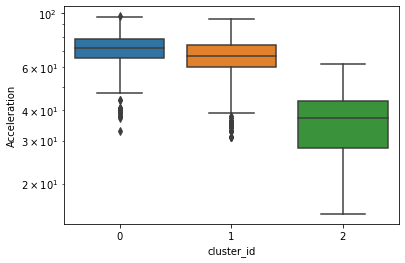

SprintSpeed


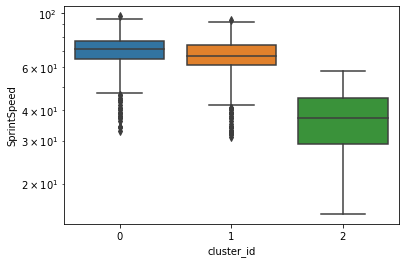

Agility


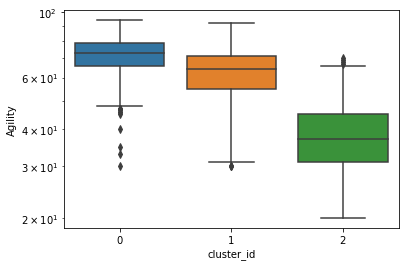

Reactions


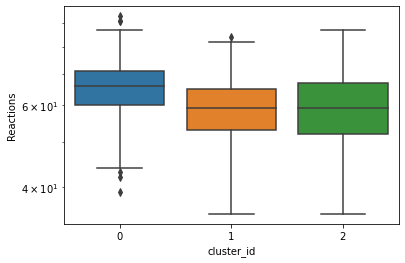

Balance


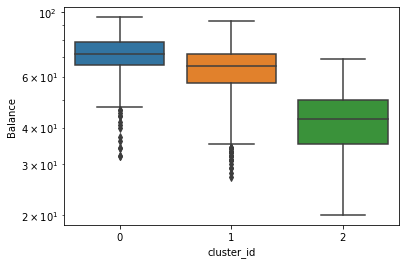

ShotPower


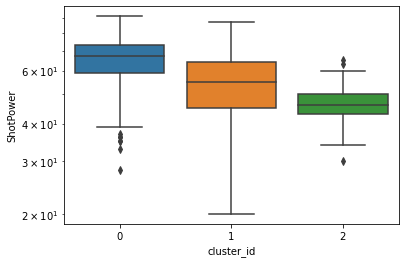

Jumping


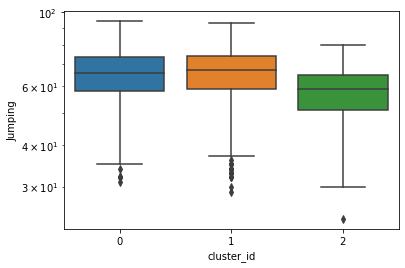

Stamina


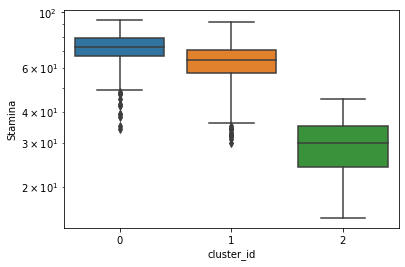

Strength


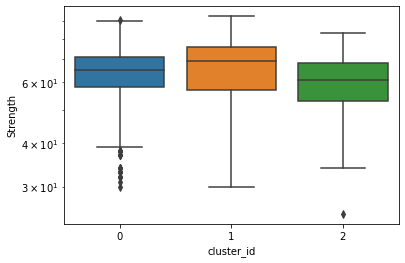

LongShots


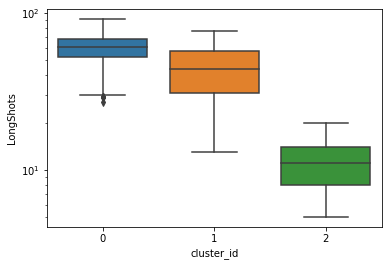

Aggression


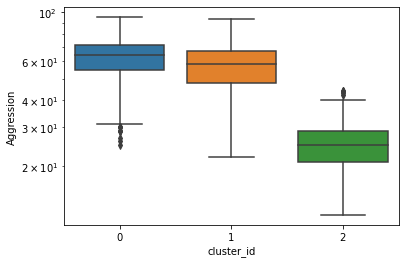

Interceptions


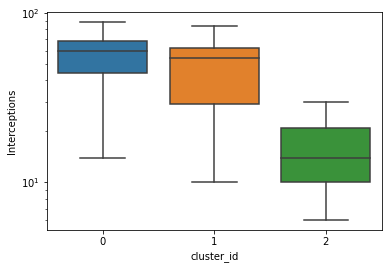

Positioning


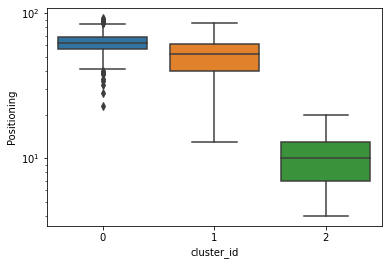

Vision


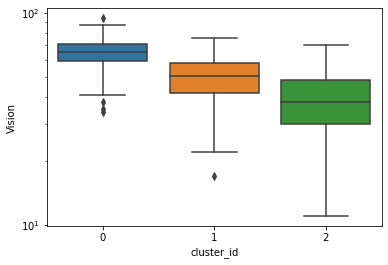

Penalties


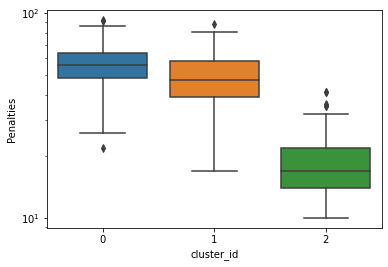

Composure


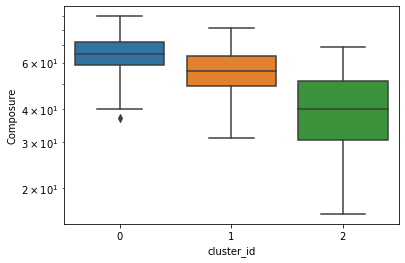

Marking


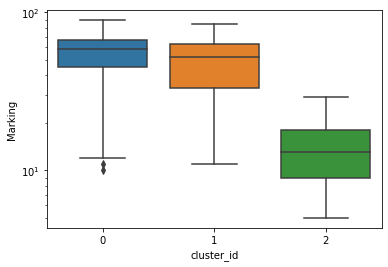

StandingTackle


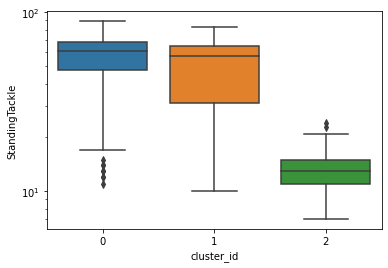

SlidingTackle


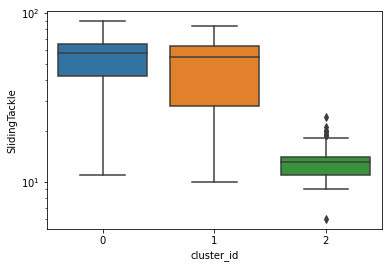

GKDiving


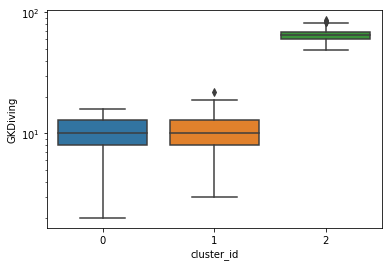

GKHandling


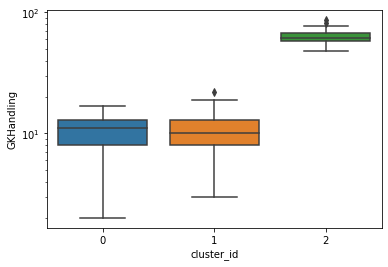

GKKicking


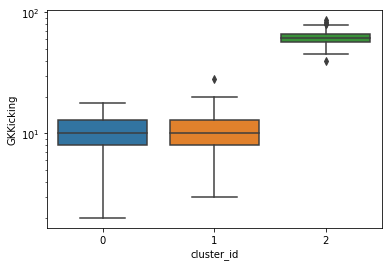

GKPositioning


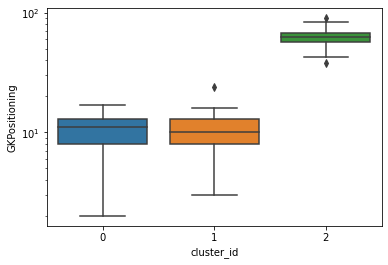

GKReflexes


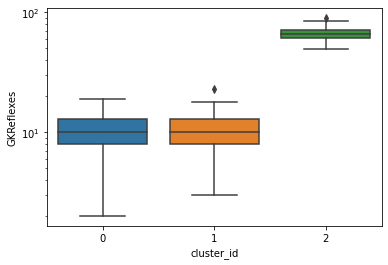

STRating


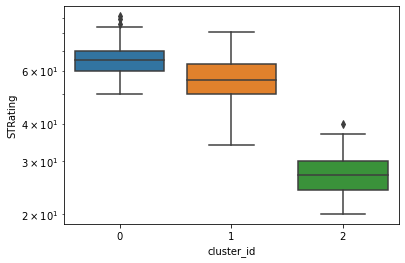

LWRating


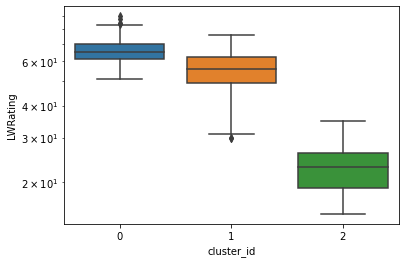

LFRating


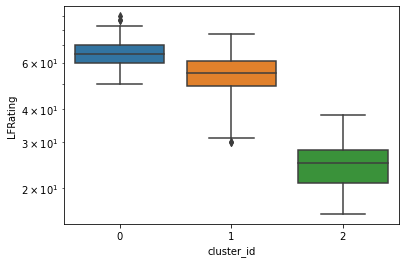

CFRating


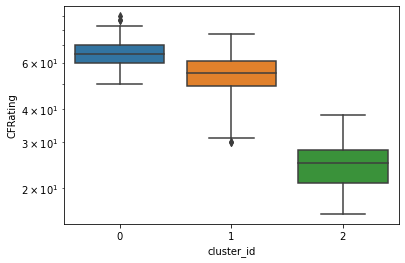

RFRating


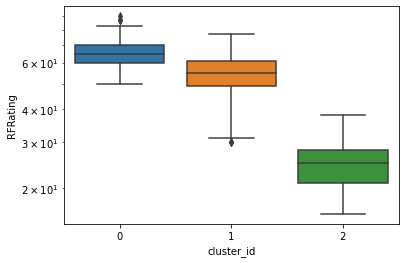

RWRating


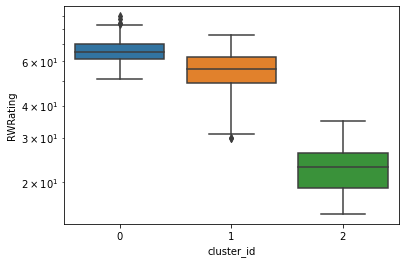

CAMRating


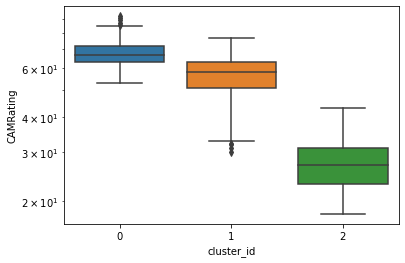

LMRating


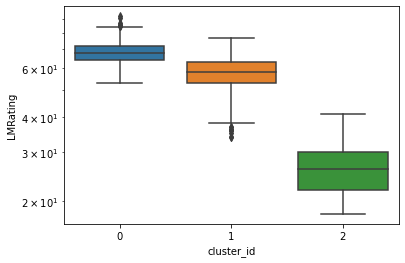

CMRating


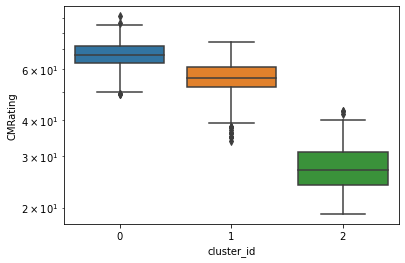

RMRating


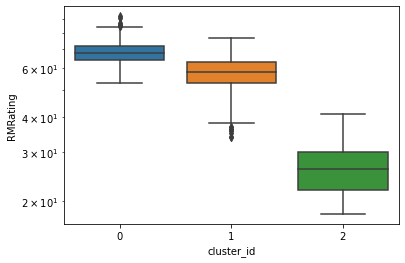

LWBRating


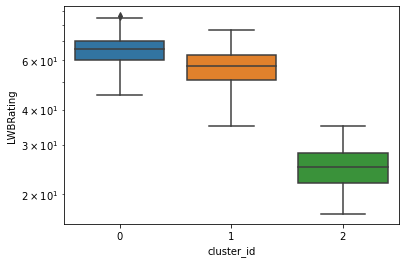

CDMRating


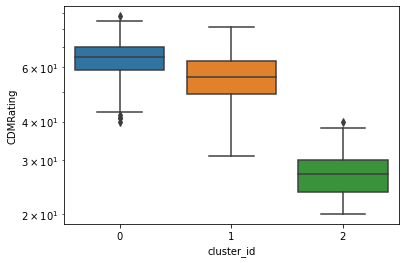

RWBRating


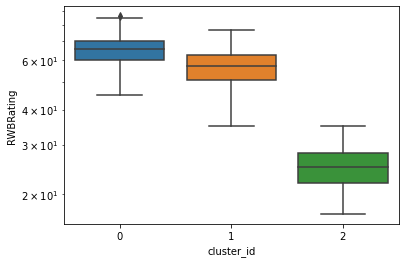

LBRating


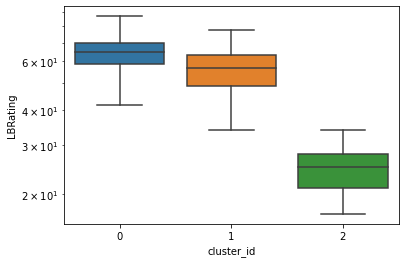

CBRating


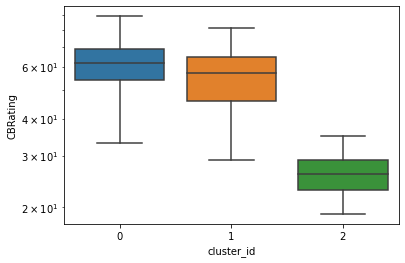

RBRating


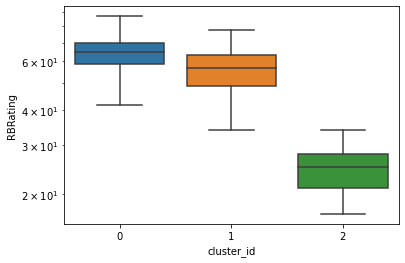

GKRating


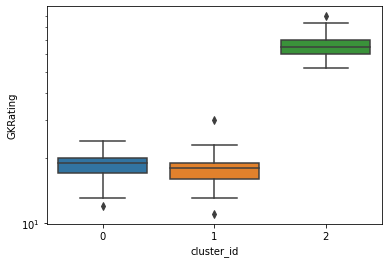

cluster_id


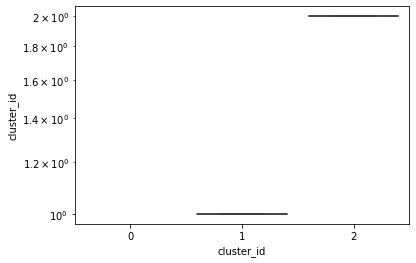

In [146]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_numeric = df.select_dtypes(include=numerics)

for col in df_numeric.columns:
    print(col)
    sns.boxplot(data = df_numeric, y = col, x='cluster_id')  
    plt.yscale("log")
    plt.show()

Z analýzy numerický atributů pomocí boxplotů můžeme vidět rozdíly i podobnosti. Sloupců je v dataframu opravdu mnoho.
Proto vyberu jen pár z ních.

'Height' nejvyšší hráču jsou ve shluku 2 pak 1 a 0. Největší rozpětí ma shluk 1.

'Weight' graf je velice podobný tomu pro 'Height' takže se dá říct o něm to samé

'Potential' všechny shluky jsou si podobné ale shlud 0  má největší průměrnou hodnotu

'TotalStats' největší hodnotu má shluk 0 pak 1 a 2



Závěrem bych chtěl říct, že jsem splnil zadání projektu. Úspěšně jsem analyzoval shluky vytvořené kmeansem i aglomerativně. Před implementování shlukování jsem musel převést všechny atributy na numerické a škálovat je. A pak vybrak ideální počet shluků pomocí metody loktu. Pak pro aglomerativní shlukování vybrat ideální parametry.

Shlukování mi příjde jako zajímá věc. Shluky jsou rozdělené na podobnosti atributů. Chápu jak funguje ve 2D prostoru ale, jak jsem teďka pracoval se skoro 2000 sloupci po škálování, tak to mi na představivost příjde težší místo 2D skoro 2000D.

Jelikož ve shlukování hraje roli náhoda. Tak jsem to dělal ze své hlouposti několikrát. Protože pokaždé při novém spuštění jupyteru se mi jinak vybralo 2000 řádků a jinak udělaly shluky.